  # Test of hierarchical classification (model 2)
  
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight

  ### Definition of names for plots and files

In [2]:

date = '20200609'

#names of files with features and labels for the training set (v7)
labels_file = '../alerce_trainingset/training_set_v7/dfcrossmatches_prioritized_v7.0.1.csv'

features_path = '/Users/psanchez/Documents/Postdoc/Alerce/new_DB/features/'

features_file = features_path+'features_for_ML_with_WISE.parquet'

#features_file = '../ZTF_data/features_20200109_phot_corrected_withWISE_withSNfeat_withMHPScorrected.csv'

class_output = '../ZTF_classifications/classes_BHRF_TSv7_original_hierarchical_classes_'+date+'.csv'

#where the RF models are saved

model_first_layer = 'final_BHRF_model/hierarchical_level_RF_model.pkl'
model_periodic_layer = 'final_BHRF_model/periodic_level_RF_model.pkl'
model_transient_layer = 'final_BHRF_model/stockastic_level_RF_model.pkl'
model_stochastic_layer = 'final_BHRF_model/transient_level_RF_model.pkl'

features_pickle = 'final_BHRF_model/features_RF_model.pkl'    
    
#confusion matrixes

conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_'+date
conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_'+date


#feature importances

feature_importance_name_first_layer = '../../paper_late_classifier/feature_importance_rf_model_2_hierarchical_layer_'+date+'.pdf'
feature_importance_name_periodic_layer = '../../paper_late_classifier/feature_importance_rf_model_2_periodic_layer_'+date+'.pdf'
feature_importance_name_transient_layer = '../../paper_late_classifier/feature_importance_rf_model_2_transient_layer_'+date+'.pdf'
feature_importance_name_stochastic_layer = '../../paper_late_classifier/feature_importance_rf_model_2_stochastic_layer_'+date+'.pdf'

### reading the training set files 

In [3]:
df_feat = pd.read_parquet(features_file)
#df_feat.set_index('oid',inplace=True)
#df_feat = pd.read_csv(features_file,index_col='oid')

df_labels = pd.read_csv(labels_file,index_col='oid')

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)
print(df_feat.head())

173879
              MHAOV_Period_1  MHAOV_Period_2  Amplitude_1  Amplitude_2  \
oid                                                                      
ZTF17aaaaavn        0.106021        0.613572     0.078912     0.097860   
ZTF17aaaadjh        0.233443        0.233454     0.493980     0.463765   
ZTF17aaaadwo        0.060049        0.216873     0.090708     0.196542   
ZTF17aaaajjv      526.315748      555.555529     0.539600     0.566276   
ZTF17aaaakjt        0.148265        0.148265     0.564867     0.572449   

              AndersonDarling_1  AndersonDarling_2  Autocor_length_1  \
oid                                                                    
ZTF17aaaaavn           0.847902           0.673712               2.0   
ZTF17aaaadjh           1.000000           1.000000               1.0   
ZTF17aaaadwo           0.903625           0.993806               1.0   
ZTF17aaaajjv           1.000000           1.000000              14.0   
ZTF17aaaakjt           0.999907           

In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['classALeRCE'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'E' #new name for paper
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'E'#new name for paper
df_labels.loc[(df_labels['class_original'] == 'Ceph'), 'class_original'] = 'CEP'#new name for paper

#df_labels = df_labels[(df_labels['source']!="ASASSN") & (df_labels['source']!="GAIADR2VS")]
#df_labels = df_labels[(df_labels['source']!="ASASSN") ]

df_labels = df_labels[(df_labels['class_source']!="ELL")]


bad_oid = ['ZTF18abslpjy','ZTF18acurqaw','ZTF18aboebre','ZTF18acvvsnu','ZTF19aaydpzi','ZTF19aatevrp','ZTF18abtteyy',
          'ZTF19aatmtne','ZTF18abtfgqr','ZTF18acetlrs','ZTF18abtmgfn','ZTF18acvvppd','ZTF18aczebty','ZTF18acefhxx',
          'ZTF18acvhggp','ZTF18adbktyj','ZTF18aarcypa','ZTF18accngee','ZTF18acwvcbz','ZTF19aacypbw','ZTF18acenqto',
          'ZTF19aapfnym','ZTF18acpefgk','ZTF18aavjcpf','ZTF18aceexmi','ZTF18accnmri','ZTF18acdvvgx',
          'ZTF18accnbgw','ZTF18acemhyb','ZTF19abqrrto','ZTF19aadolpe','ZTF18abxbmqh','ZTF20aacbwbm']

df_labels.drop(bad_oid,inplace=True)


#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[ (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'CV/Nova')  |(labels['class_hierachical'] == 'YSO') |     (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(173041,)


class_original class_hierachical
oid                                          
ZTF19abegncu            AGN        Stochastic
ZTF18acejdhu            AGN        Stochastic
ZTF18acdzene            AGN        Stochastic
ZTF18abwzuzw            AGN        Stochastic
ZTF19abmposz            AGN        Stochastic

In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',  
#'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro',
#'w1mag', 'w2mag' ,'w3mag','w4mag',
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
#'g-r_max_corr',
#'g-r_mean_corr',
#'g-r_mean',
'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
#print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
#print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

#print(df['g-r_max'].values.size)
df.head()

123496


Amplitude_1  Amplitude_2  AndersonDarling_1  AndersonDarling_2  \
oid                                                                            
ZTF19aapcxhy     0.068704     0.052665           0.665183           0.501831   
ZTF18abtmwvo     0.115177  -999.000000           0.996398        -999.000000   
ZTF18acvgdfy     0.050608  -999.000000           0.353987        -999.000000   
ZTF19aabvjsi  -999.000000     0.028547        -999.000000           0.494246   
ZTF18aadyxlg  -999.000000     0.021935        -999.000000           0.543918   

              Autocor_length_1  Autocor_length_2  Beyond1Std_1  Beyond1Std_2  \
oid                                                                            
ZTF19aapcxhy               1.0               1.0      0.250000      0.307692   
ZTF18abtmwvo               1.0            -999.0      0.428571   -999.000000   
ZTF18acvgdfy               1.0            -999.0      0.500000   -999.000000   
ZTF19aabvjsi            -999.0               1.0   -999.000000      0.333333   
ZTF18aadyxlg            -999.0               1.0   -999.000000      0.500000   

              Con_1  Con_2  ...        rb  sgscore1  W1-W2  W2-W3        r-W3  \
oid                         ...                                                 
ZTF19aapcxhy    0.0    0.0  ...  0.780000  0.013542  0.796  2.889    8.106832   
ZTF18abtmwvo    0.0 -999.0  ...  0.717857  0.216488  0.807  2.964 -999.000000   
ZTF18acvgdfy    0.0 -999.0  ...  0.683333  0.088542  0.606  2.876 -999.000000   
ZTF19aabvjsi -999.0    0.0  ...  0.683333  0.035875  0.938  3.017    8.099364   
ZTF18aadyxlg -999.0    0.0  ...  0.683333  0.161542  0.959  3.021    8.041334   

                    r-W2        g-W3        g-W2  delta_period_1  \
oid                                                                
ZTF19aapcxhy    5.217832    8.668390    5.779390        0.202128   
ZTF18abtmwvo -999.000000    9.126021    6.162021        0.081005   
ZTF18acvgdfy -999.000000    8.483215    5.607215        0.023222   
ZTF19aabvjsi    5.082364 -999.000000 -999.000000     -999.000000   
ZTF18aadyxlg    5.020334 -999.000000 -999.000000     -999.000000   

              delta_period_2  
oid                           
ZTF19aapcxhy        1.155121  
ZTF18abtmwvo     -999.000000  
ZTF18acvgdfy     -999.000000  
ZTF19aabvjsi        0.529107  
ZTF18aadyxlg        0.277404  

[5 rows x 152 columns]

In [6]:
#print(df.columns)
print(np.array(df.columns))
print(len(np.array(df.columns)))

['Amplitude_1' 'Amplitude_2' 'AndersonDarling_1' 'AndersonDarling_2'
 'Autocor_length_1' 'Autocor_length_2' 'Beyond1Std_1' 'Beyond1Std_2'
 'Con_1' 'Con_2' 'Eta_e_1' 'Eta_e_2' 'ExcessVar_1' 'ExcessVar_2'
 'GP_DRW_sigma_1' 'GP_DRW_sigma_2' 'GP_DRW_tau_1' 'GP_DRW_tau_2' 'Gskew_1'
 'Gskew_2' 'Harmonics_mag_1_1' 'Harmonics_mag_1_2' 'Harmonics_mag_2_1'
 'Harmonics_mag_2_2' 'Harmonics_mag_3_1' 'Harmonics_mag_3_2'
 'Harmonics_mag_4_1' 'Harmonics_mag_4_2' 'Harmonics_mag_5_1'
 'Harmonics_mag_5_2' 'Harmonics_mag_6_1' 'Harmonics_mag_6_2'
 'Harmonics_mag_7_1' 'Harmonics_mag_7_2' 'Harmonics_mse_1'
 'Harmonics_mse_2' 'Harmonics_phase_2_1' 'Harmonics_phase_2_2'
 'Harmonics_phase_3_1' 'Harmonics_phase_3_2' 'Harmonics_phase_4_1'
 'Harmonics_phase_4_2' 'Harmonics_phase_5_1' 'Harmonics_phase_5_2'
 'Harmonics_phase_6_1' 'Harmonics_phase_6_2' 'Harmonics_phase_7_1'
 'Harmonics_phase_7_2' 'IAR_phi_1' 'IAR_phi_2' 'LinearTrend_1'
 'LinearTrend_2' 'MHPS_high_1' 'MHPS_high_2' 'MHPS_low_1' 'MHPS_low_2'
 'MHPS_rati

In [7]:
for idx, cl in enumerate(label_order):
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 1272
SNIbc 94
SNII 328
SLSN 24
QSO 26168
AGN 4667
Blazar 1267
YSO 1740
CV/Nova 871
LPV 14076
E 37901
DSCT 732
RRL 32482
CEP 618
Periodic-Other 1256


Counter({'E': 37901, 'RRL': 32482, 'QSO': 26168, 'LPV': 14076, 'AGN': 4667, 'YSO': 1740, 'SNIa': 1272, 'Blazar': 1267, 'Periodic-Other': 1256, 'CV/Nova': 871, 'DSCT': 732, 'CEP': 618, 'SNII': 328, 'SNIbc': 94, 'SLSN': 24})
                number
E                37901
RRL              32482
QSO              26168
LPV              14076
AGN               4667
YSO               1740
SNIa              1272
Blazar            1267
Periodic-Other    1256
CV/Nova            871
DSCT               732
CEP                618
SNII               328
SNIbc               94
SLSN                24


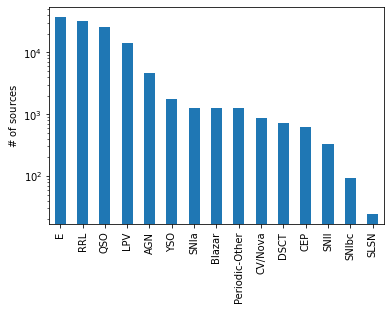

In [8]:
class_counts = Counter(labels['class_original'])
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)


plt.yscale('log')
#plt.title('sources classified')
plt.ylabel(r'$\#$ of sources')

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/number_sources_labeled_set.pdf',bbox_inches='tight')

  ### Defining functions to plot the confusion matrix and the feature importance

In [9]:
'''def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'
    if extragalactic: title='Confusion matrix for |gal_b|>20'
    if galactic: title='Confusion matrix for |gal_b|<=20'


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()'''
    
    
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    


def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    for i in I[0:30]:
        print(feature_names[i], "& %.3f" % (model.feature_importances_[i]))
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name, bbox_inches='tight')
    #plt.close()

### Pre-processing training data

In [10]:
Y_hierarchical = labels['class_hierachical']
Y_original = labels['class_original']

print(len(labels['class_hierachical'].values))
print(len(labels['class_original'].values))
X_hierarchical = df

#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
          Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

X_test_periodic = X_test_hierarchical
X_test_stochastic = X_test_hierarchical
X_test_transient = X_test_hierarchical

print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

123496
123496
69651 27771 1374


In [57]:
print(X_train_hierarchical.index)
print(X_test_hierarchical.index)

np.save('final_BHRF_model/labels_training_sample', X_train_hierarchical.index.values)
np.save('final_BHRF_model/labels_testint_sample', X_test_hierarchical.index.values)

Index(['ZTF18acnnqmx', 'ZTF18aajxkux', 'ZTF18aajqttp', 'ZTF18abdkhzq',
       'ZTF18abvtqlk', 'ZTF18aazluiy', 'ZTF18abypodv', 'ZTF18absumxg',
       'ZTF17aaadycq', 'ZTF18aagteha',
       ...
       'ZTF18acpddvk', 'ZTF18abbwygc', 'ZTF18abaqxsf', 'ZTF18abmnjqn',
       'ZTF19abeyxcq', 'ZTF19acectth', 'ZTF19aamkvoo', 'ZTF18abcltjs',
       'ZTF18abmqufr', 'ZTF19aamwqwo'],
      dtype='object', name='oid', length=98796)
Index(['ZTF18aauqsiu', 'ZTF18abkbxre', 'ZTF18ablpepc', 'ZTF19aaqtlws',
       'ZTF18aaadtdc', 'ZTF18abxwetq', 'ZTF18abcralj', 'ZTF20aaoyqoz',
       'ZTF20aadayup', 'ZTF20aawkofv',
       ...
       'ZTF18aajsvpy', 'ZTF18abtxvlc', 'ZTF18acwynmj', 'ZTF18aaadvds',
       'ZTF20aahpzsh', 'ZTF18abcmsej', 'ZTF18abvfsrv', 'ZTF17aacqsrz',
       'ZTF18abcjqpo', 'ZTF19aaycprb'],
      dtype='object', name='oid', length=24700)


  ## Balanced random forest
  
  ### First layer: separating Periodic, Stochastic and Transients:

In [11]:
#Training first layer of the RF model

rf_model_hierarchical = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

#testing first layer performance

y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
print(classes_order_proba_hierarchical)


print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_train_hierarchical)
        
with open(model_first_layer, 'wb') as f:
            pickle.dump(
                rf_model_hierarchical,
                f,
                pickle.HIGHEST_PROTOCOL)

['Periodic' 'Stochastic' 'Transient']
Accuracy: 0.9874898785425101
Balanced accuracy: 0.9866961952421404


[[  343     0     1]
 [   21  6719   202]
 [   14    71 17329]]
Normalized confusion matrix
[[100.   0.   0.]
 [  0.  97.   3.]
 [  0.   0. 100.]]


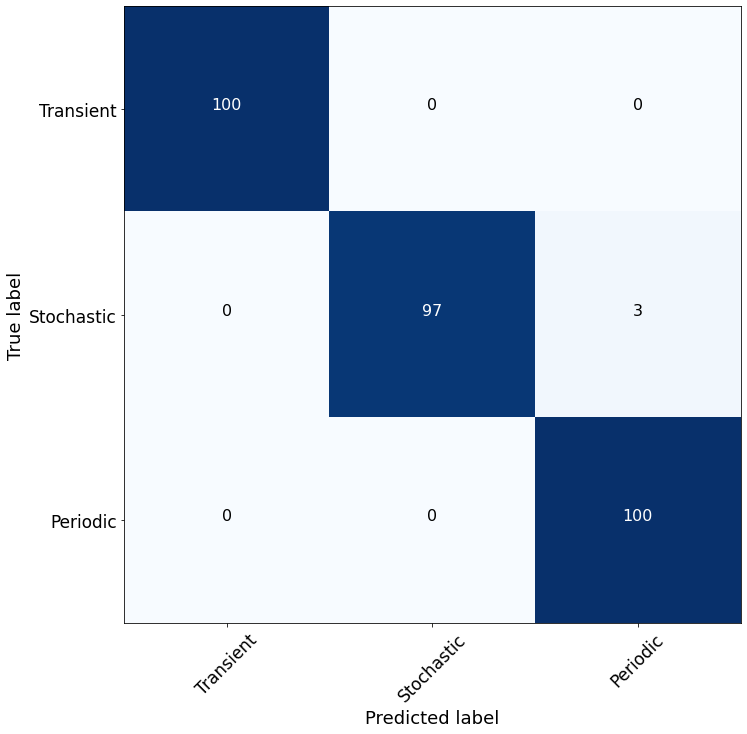

In [12]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,'../../paper_late_classifier/paper_plots_2nd_version/training_conf_matrix_hierarchical_level.pdf')

W1-W2 & 0.094
sgscore1 & 0.053
positive_fraction_2 & 0.050
positive_fraction_1 & 0.048
SPM_tau_rise_1 & 0.035
LinearTrend_2 & 0.032
SPM_chi_1 & 0.031
g-W2 & 0.031
g-W3 & 0.031
n_non_det_after_fid_2 & 0.026
W2-W3 & 0.025
SPM_beta_1 & 0.024
SPM_tau_rise_2 & 0.023
SPM_A_2 & 0.023
SPM_chi_2 & 0.020
SPM_A_1 & 0.019
r-W2 & 0.018
ExcessVar_1 & 0.017
ExcessVar_2 & 0.016
r-W3 & 0.014
Rcs_2 & 0.013
GP_DRW_sigma_2 & 0.013
SPM_tau_fall_1 & 0.013
Meanvariance_2 & 0.012
LinearTrend_1 & 0.012
SPM_beta_2 & 0.010
Pvar_2 & 0.010
MHPS_low_2 & 0.009
SF_ML_amplitude_2 & 0.009
g-r_max_corr & 0.009


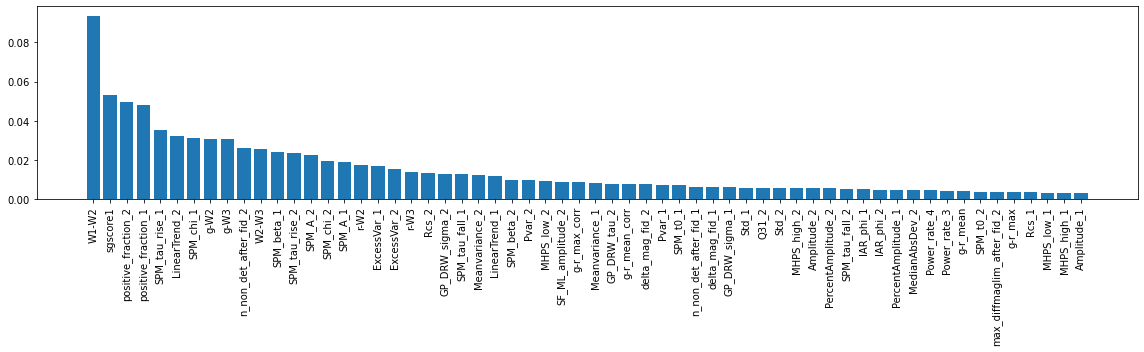

In [13]:
#plotting feature importance
plot_feature_importances(rf_model_hierarchical, features_hierarchical, 'final_BHRF_model/feature_ranking_hierarchical_level.pdf')

  ### Periodic layer

In [14]:
#Training Periodic layer

rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight='balanced_subsample',
            bootstrap=True,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(X_train_periodic, y_train_periodic)


# Applying periodic model to the test data
y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)

#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as f:
            pickle.dump(
                rf_model_periodic,
                f,
                pickle.HIGHEST_PROTOCOL)

['CEP' 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']


89
Multiband_period & 0.089
g-W2 & 0.062
r-W2 & 0.034
g-r_max_corr & 0.030
g-W3 & 0.028
g-r_mean & 0.027
g-r_max & 0.025
GP_DRW_tau_1 & 0.023
g-r_mean_corr & 0.022
IAR_phi_1 & 0.022
Amplitude_1 & 0.017
ExcessVar_1 & 0.017
delta_mag_fid_1 & 0.016
Meanvariance_1 & 0.016
r-W3 & 0.016
Std_1 & 0.015
GP_DRW_sigma_1 & 0.015
GP_DRW_tau_2 & 0.012
PercentAmplitude_1 & 0.012
W1-W2 & 0.009
W2-W3 & 0.009
SF_ML_amplitude_1 & 0.009
SPM_A_1 & 0.009
Gskew_1 & 0.009
Q31_1 & 0.009
Autocor_length_1 & 0.009
IAR_phi_2 & 0.008
SF_ML_gamma_1 & 0.008
Amplitude_2 & 0.007
delta_mag_fid_2 & 0.007


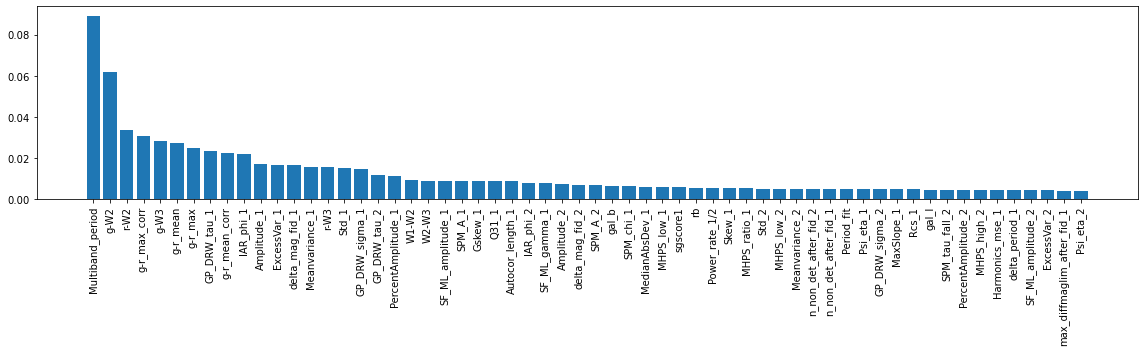

In [15]:
#plotting feature importance
print(len(feature_importance_name_first_layer))
plot_feature_importances(rf_model_periodic, features_periodic, 'final_BHRF_model/feature_ranking_periodic_level.pdf')

  ### Stochastic layer

In [16]:
#Training Stochastic layer

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features=0.2,#'auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)


# Applying stochastic model to the test data
y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)


with open(model_stochastic_layer, 'wb') as f:
            pickle.dump(
                rf_model_stochastic,
                f,
                pickle.HIGHEST_PROTOCOL)

['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO']


W1-W2 & 0.109
sgscore1 & 0.058
r-W2 & 0.049
g-r_mean_corr & 0.048
g-W2 & 0.046
gal_b & 0.045
g-W3 & 0.037
g-r_max_corr & 0.035
ExcessVar_2 & 0.033
Meanvariance_2 & 0.026
g-r_mean & 0.025
delta_mag_fid_2 & 0.024
r-W3 & 0.023
W2-W3 & 0.022
Amplitude_2 & 0.022
Std_2 & 0.015
g-r_max & 0.015
SPM_A_2 & 0.014
PercentAmplitude_2 & 0.013
SPM_A_1 & 0.012
ExcessVar_1 & 0.011
IAR_phi_1 & 0.010
GP_DRW_sigma_2 & 0.009
delta_mag_fid_1 & 0.009
Pvar_2 & 0.007
IAR_phi_2 & 0.007
GP_DRW_tau_2 & 0.007
GP_DRW_tau_1 & 0.007
MHPS_high_1 & 0.007
MHPS_low_1 & 0.006


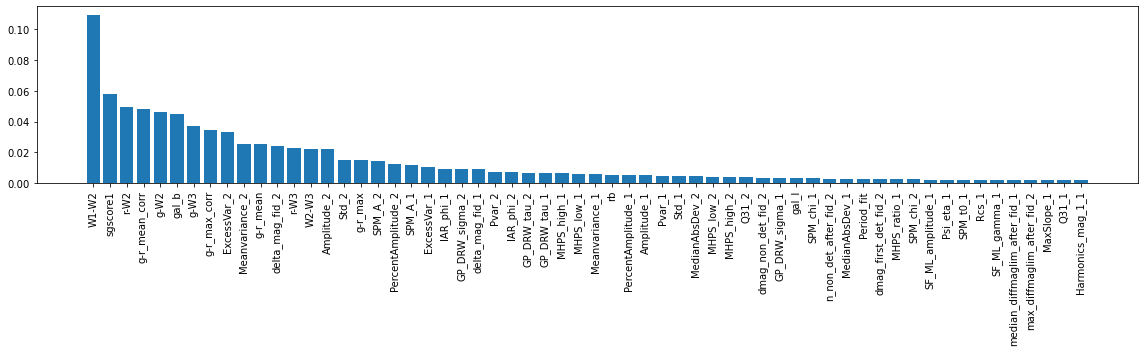

In [17]:
#plotting feature importance
plot_feature_importances(rf_model_stochastic, features_stochastic, 'final_BHRF_model/feature_ranking_stochastic_level.pdf')


  ### Transient layer

In [18]:
#Training Transient layer

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as f:
            pickle.dump(
                rf_model_transient,
                f,
                pickle.HIGHEST_PROTOCOL)
        
with open(features_pickle, 'wb') as f:
            pickle.dump(
                features_transient,
                f,
                pickle.HIGHEST_PROTOCOL)

['SLSN' 'SNII' 'SNIa' 'SNIbc']


SPM_t0_1 & 0.033
SPM_beta_2 & 0.029
SPM_tau_rise_2 & 0.028
SPM_tau_rise_1 & 0.025
g-r_max & 0.023
SPM_t0_2 & 0.022
LinearTrend_2 & 0.019
AndersonDarling_2 & 0.018
SPM_beta_1 & 0.017
SPM_tau_fall_2 & 0.017
dmag_first_det_fid_1 & 0.015
MHPS_low_1 & 0.013
LinearTrend_1 & 0.013
g-r_mean & 0.012
MHPS_ratio_1 & 0.011
SPM_tau_fall_1 & 0.011
SPM_gamma_2 & 0.011
MHPS_ratio_2 & 0.010
Skew_2 & 0.009
sgscore1 & 0.009
SPM_gamma_1 & 0.009
Power_rate_2 & 0.009
IAR_phi_2 & 0.009
dmag_first_det_fid_2 & 0.009
IAR_phi_1 & 0.009
last_diffmaglim_before_fid_1 & 0.009
Period_fit & 0.008
Harmonics_mag_6_1 & 0.008
MHPS_low_2 & 0.008
Gskew_2 & 0.008


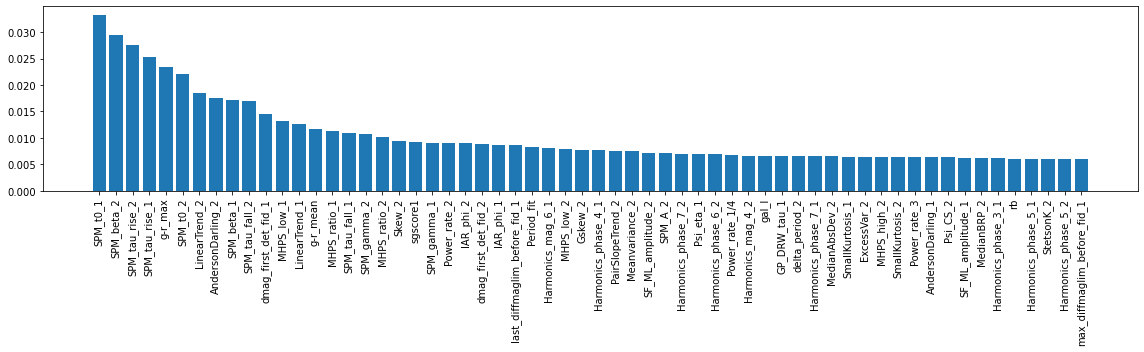

In [19]:
#plotting feature importance
plot_feature_importances(rf_model_transient, features_transient, 'final_BHRF_model/feature_ranking_transient_level.pdf')



 ## Putting al layers together  


In [20]:
# generating final probabilities

#multiplying probabilities of the hierarchical layer with the other layers
prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = [prob_final_class_names[x] for x in class_final_index]



[1. 1. 1. ... 1. 1. 1.] 1.0 7.765137331658304e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']


[[ 193   49   10    1    0    0    0    0    0    0    0    0    0    0
     1]
 [   5   11    2    1    0    0    0    0    0    0    0    0    0    0
     0]
 [   9   13   36    8    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    5    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    3 4569  405  234    4   18    0    1    0    0    0
     0]
 [   0    0    1    0   93  789   40    5    2    1    0    0    0    0
     2]
 [   0    0    0    0   35   22  191    0    3    2    0    0    0    0
     0]
 [   0    0    0    0    0    0    2  270    1   18    2    1    2   13
    39]
 [   3    2    2    0    0    0    1    3  124    1    8    9   16    4
     1]
 [   0    2    0    0    1    0    1   27    0 2749    0    0    0   18
    17]
 [   0    0    0    0    7    0    2   35   58    4 5575  460  261  275
   904]
 [   0    0    0    0    0    0    0    0    0    0    9  130    3    1
     3]
 [   0    0    1    0    6    0    1   1

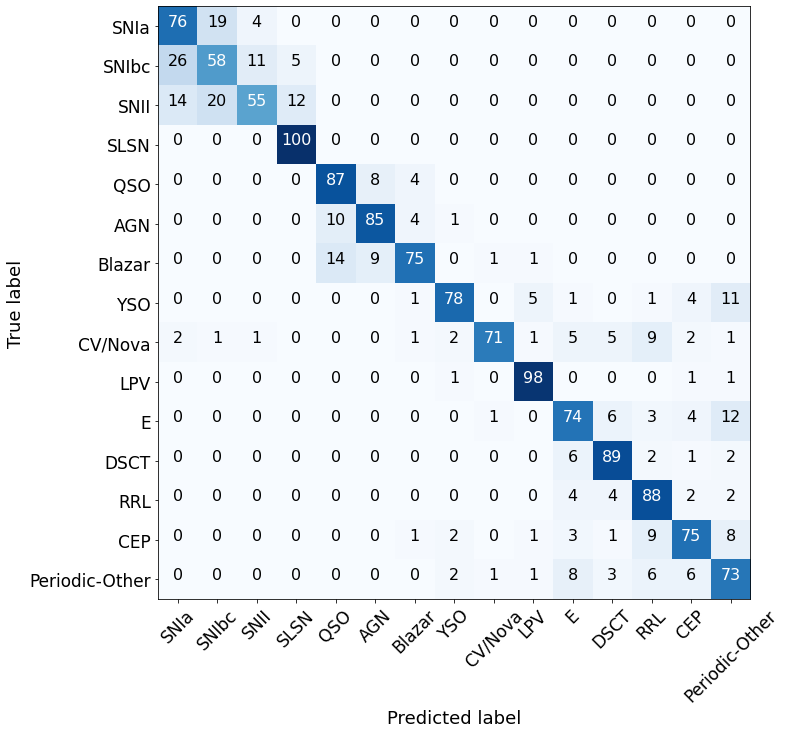

In [21]:
# generating confusion matrix for multilabels
cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order, '../../paper_late_classifier/paper_plots_2nd_version/conf_matrix_multiclass_level.pdf')

print("Accuracy:", "%0.2f" % metrics.accuracy_score(y_test_original, class_final_name))
print("Balanced accuracy:","%0.2f" %  metrics.balanced_accuracy_score(y_test_original, class_final_name))

print("macro precision: ","%0.2f" %  metrics.precision_score(y_test_original, class_final_name, average='macro'))
print("macro recall: ","%0.2f" %  metrics.recall_score(y_test_original, class_final_name, average='macro'))
print("macro F1: ","%0.2f" %  metrics.f1_score(y_test_original, class_final_name, average='macro'))

print(metrics.classification_report(y_test_original, class_final_name, digits=2))

In [22]:
# Kaggle score

num_y_test =  class_final_index
class_weights = list(class_weight.compute_class_weight('balanced', label_order, y_test_original))

print(class_weights)

CLASSES_REDUCED_V2 = label_order

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,prob_final))

[6.482939632545932, 86.66666666666667, 24.949494949494948, 329.3333333333333, 0.3146096038721182, 1.7649160414433727, 6.508563899868248, 4.731800766283525, 9.46360153256705, 0.5849615156897573, 0.2172096908939014, 11.278538812785389, 0.25345031039967164, 13.279569892473118, 6.560424966799469]
SNIa -0.03238147714010252
SNIbc -0.050699892023106596
SNII -0.07062891346322829
SLSN -0.024423459205911192
QSO -0.052989417944133366
AGN -0.07218592536048425
Blazar -0.07448437134716436
YSO -0.0665495460681522
CV/Nova -0.07385250708966482
LPV -0.0595632306802242
E -0.062236657578391745
DSCT -0.044767907667650195
RRL -0.019664289499837742
CEP -0.06225405712828001
Periodic-Other -0.03328732286665396
0.7999689750629855


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=['SNIa', 'SNIbc', 'SNII', 'SLSN', 'QSO', 'AGN', 'Blazar', 'YSO', 'CV/Nova', 'LPV', 'E', 'DSCT', 'RRL', 'CEP', 'Periodic-Other'], y=oid
ZTF18aauqsiu    LPV
ZTF18abkbxre      E
ZTF18ablpepc    LPV
ZTF19aaqtlws    QSO
ZTF18aaadtdc    AGN
               ... 
ZTF18abcmsej    CEP
ZTF18abvfsrv    AGN
ZTF17aacqsrz      E
ZTF18abcjqpo      E
ZTF19aaycprb    QSO
Name: class_original, Length: 24700, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


  ## Classifying unlabeled data

In [23]:
#loading the data
print(rm_nd_cols)

mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)

df_feat_ul_out = df_feat_ul

df_feat_ul.head()

['n_det_1', 'n_det_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'first_mag_1', 'first_mag_2', 'MHPS_non_zero_1', 'MHPS_non_zero_2', 'MHPS_PN_flag_1', 'MHPS_PN_flag_2', 'mean_mag_1', 'mean_mag_2', 'min_mag_1', 'min_mag_2', 'W1', 'W2', 'W3', 'W4', 'iqr_1', 'iqr_2', 'delta_mjd_fid_1', 'delta_mjd_fid_2', 'last_mjd_before_fid_1', 'last_mjd_before_fid_2', 'g-r_ml', 'MHAOV_Period_1', 'MHAOV_Period_2']


Amplitude_1  Amplitude_2  AndersonDarling_1  AndersonDarling_2  \
oid                                                                            
ZTF17aaaaavn     0.078912     0.097860           0.847902           0.673712   
ZTF17aaaadjh     0.493980     0.463765           1.000000           1.000000   
ZTF17aaaadwo     0.090708     0.196542           0.903625           0.993806   
ZTF17aaaajjv     0.539600     0.566276           1.000000           1.000000   
ZTF17aaaakjt     0.564867     0.572449           0.999907           0.990501   

              Autocor_length_1  Autocor_length_2  Beyond1Std_1  Beyond1Std_2  \
oid                                                                            
ZTF17aaaaavn               2.0               1.0      0.380952      0.428571   
ZTF17aaaadjh               1.0               1.0      0.279070      0.293103   
ZTF17aaaadwo               1.0               1.0      0.368421      0.285714   
ZTF17aaaajjv              14.0              20.0      0.419580      0.481203   
ZTF17aaaakjt               1.0               1.0      0.338462      0.350000   

              Con_1  Con_2  ...        rb  sgscore1  W1-W2  W2-W3      r-W3  \
oid                         ...                                               
ZTF17aaaaavn    0.0    0.0  ...  0.738809  0.989375 -0.301  1.491  4.239709   
ZTF17aaaadjh    0.0    0.0  ...  0.742857  1.000000 -0.125  2.380  4.533904   
ZTF17aaaadwo    0.0    0.0  ...  0.737143  0.992667 -0.065  1.602  4.344352   
ZTF17aaaajjv    0.0    0.0  ...  0.743333  1.000000 -0.040  0.997  7.765696   
ZTF17aaaakjt    0.0    0.0  ...  0.818571  0.975000 -0.027  0.027  3.161238   

                  r-W2       g-W3      g-W2  delta_period_1  delta_period_2  
oid                                                                          
ZTF17aaaaavn  2.748709   5.350475  3.859475        0.017990    4.895612e-01  
ZTF17aaaadjh  2.153904   5.281445  2.901445        0.000011    5.197596e-08  
ZTF17aaaadwo  2.742352   5.495974  3.893974        0.423044    2.662193e-01  
ZTF17aaaajjv  6.768696  10.193531  9.196531       29.239637    1.437226e-04  
ZTF17aaaakjt  3.134238   4.298826  4.271826        0.000002    2.169809e-06  

[5 rows x 152 columns]

In [24]:
#predicting classes of unlabeled data

test_Y_hierarchical = rf_model_hierarchical.predict(df_feat_ul)
test_Y_proba_hierarchical = rf_model_hierarchical.predict_proba(df_feat_ul)

test_Y_periodic = rf_model_periodic.predict(df_feat_ul)
test_Y_proba_periodic = rf_model_periodic.predict_proba(df_feat_ul)

test_Y_stochastic = rf_model_stochastic.predict(df_feat_ul)
test_Y_proba_stochastic = rf_model_stochastic.predict_proba(df_feat_ul)

test_Y_transient = rf_model_transient.predict(df_feat_ul)
test_Y_proba_transient = rf_model_transient.predict_proba(df_feat_ul)


#multiplying probabilities
prob_periodic_ul = test_Y_proba_periodic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic_ul = test_Y_proba_stochastic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient_ul = test_Y_proba_transient*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final_ul = np.concatenate((prob_stochastic_ul,prob_trainsient_ul,prob_periodic_ul),axis=1)

print(np.sum(prob_final_ul,axis=1),np.mean(np.sum(prob_final_ul,axis=1)),np.std(np.sum(prob_final_ul,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names_ul = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba_ul = np.amax(prob_final_ul,axis=1)
class_final_index_ul = np.argmax(prob_final_ul,axis=1)
class_final_name_ul = [prob_final_class_names_ul[x] for x in class_final_index_ul]


[1. 1. 1. ... 1. 1. 1.] 1.0 8.646543515627613e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']


In [25]:
#Writing results in the output
df_out = df_feat
print(df_out.shape)
print(len(class_final_name_ul))
print(len(prob_final_ul))


df_out['predicted_class'] = class_final_name_ul
df_out['predicted_class_proba'] = class_final_proba_ul
test_data_withclass = df_out


probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

#test_data_withclass.to_csv(class_output)

test_data_withclass.head()


(868371, 183)
868371
868371


MHAOV_Period_1  MHAOV_Period_2  Amplitude_1  Amplitude_2  \
oid                                                                      
ZTF17aaaaavn        0.106021        0.613572     0.078912     0.097860   
ZTF17aaaadjh        0.233443        0.233454     0.493980     0.463765   
ZTF17aaaadwo        0.060049        0.216873     0.090708     0.196542   
ZTF17aaaajjv      526.315748      555.555529     0.539600     0.566276   
ZTF17aaaakjt        0.148265        0.148265     0.564867     0.572449   

              AndersonDarling_1  AndersonDarling_2  Autocor_length_1  \
oid                                                                    
ZTF17aaaaavn           0.847902           0.673712               2.0   
ZTF17aaaadjh           1.000000           1.000000               1.0   
ZTF17aaaadwo           0.903625           0.993806               1.0   
ZTF17aaaajjv           1.000000           1.000000              14.0   
ZTF17aaaakjt           0.999907           0.990501               1.0   

              Autocor_length_2  Beyond1Std_1  Beyond1Std_2  ...  SNIbc_prob  \
oid                                                         ...               
ZTF17aaaaavn               1.0      0.380952      0.428571  ...    0.003680   
ZTF17aaaadjh               1.0      0.279070      0.293103  ...    0.000000   
ZTF17aaaadwo               1.0      0.368421      0.285714  ...    0.000456   
ZTF17aaaajjv              20.0      0.419580      0.481203  ...    0.000624   
ZTF17aaaakjt               1.0      0.338462      0.350000  ...    0.000000   

              CEP_prob  DSCT_prob    E_prob  LPV_prob  Periodic-Other_prob  \
oid                                                                          
ZTF17aaaaavn  0.036504   0.018928  0.156832  0.021632             0.429936   
ZTF17aaaadjh  0.096628   0.025636  0.658648  0.003944             0.047328   
ZTF17aaaadwo  0.075164   0.019228  0.213256  0.013984             0.529644   
ZTF17aaaajjv  0.001952   0.000000  0.000000  0.974048             0.000000   
ZTF17aaaakjt  0.246784   0.023136  0.485856  0.009640             0.080976   

              RRL_prob  prob_Periodic  prob_Stochastic  prob_Transient  
oid                                                                     
ZTF17aaaaavn  0.012168          0.676            0.308           0.016  
ZTF17aaaadjh  0.153816          0.986            0.014           0.000  
ZTF17aaaadwo  0.022724          0.874            0.124           0.002  
ZTF17aaaajjv  0.000000          0.976            0.020           0.004  
ZTF17aaaakjt  0.117608          0.964            0.036           0.000  

[5 rows x 203 columns]

In [47]:
test_data_withclass.to_csv(class_output)

Counter({'Periodic-Other': 243374, 'E': 198122, 'LPV': 161592, 'YSO': 85087, 'RRL': 58592, 'QSO': 43054, 'DSCT': 26672, 'CEP': 17307, 'AGN': 14342, 'CV/Nova': 7945, 'Blazar': 5085, 'SNIa': 3956, 'SNIbc': 1626, 'SNII': 890, 'SLSN': 727})
                number
Periodic-Other  243374
E               198122
LPV             161592
YSO              85087
RRL              58592
QSO              43054
DSCT             26672
CEP              17307
AGN              14342
CV/Nova           7945
Blazar            5085
SNIa              3956
SNIbc             1626
SNII               890
SLSN               727


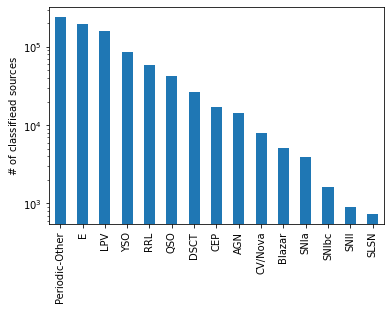

In [27]:
class_counts = Counter(class_final_name_ul)
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)

plt.yscale('log')
#plt.title('sources classified')
plt.ylabel(r'$\#$ of classifiead sources')

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/number_classified_sources.pdf',bbox_inches='tight')

0 SNIa 0.962
1 SNIbc 0.906
2 SNII 0.9
3 SLSN 0.726
4 QSO 0.992
5 AGN 0.946
6 Blazar 0.862
7 YSO 0.44
8 CV/Nova 0.43
9 LPV 0.782
10 E 0.952
11 DSCT 0.912
12 RRL 0.966
13 CEP 0.882
14 Periodic-Other 0.788


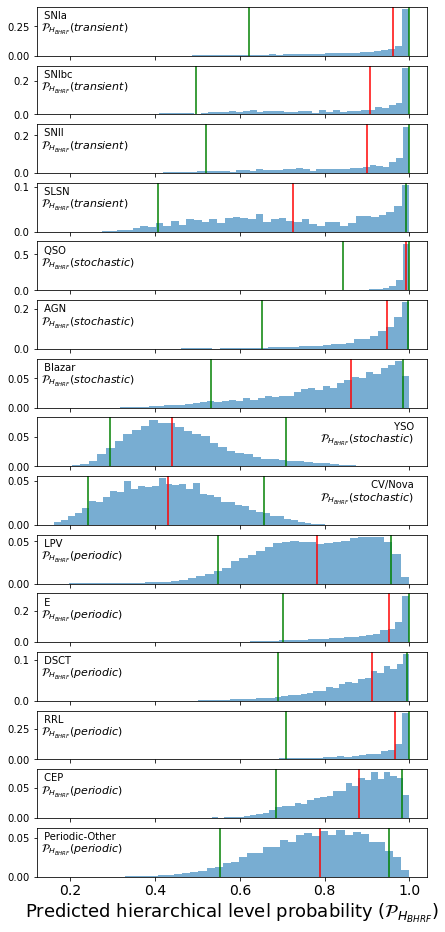

In [28]:
#plotting hierarchical level probabilities
fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(7, 16), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   if cl=="QSO" or cl=="AGN" or cl=='YSO' or cl=='CV/Nova' or cl=="Blazar":
        prob = 'prob_Stochastic'
   elif cl=="SNIa" or cl=="SNIbc" or cl=='SNII' or cl=='SLSN':
        prob = 'prob_Transient'
   else:      
        prob = 'prob_Periodic'
        
   print(idx, cl, np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   weights = np.ones_like(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values)/float(len(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values))
   nn,binsn,aux=ax[idx].hist(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='stepfilled', bins=40, lw=5, label=cl, alpha=0.6)
   if (cl=="YSO") or (cl=="CV/Nova")  : 
       ax[idx].text(1.01, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='right')
   else: 
       ax[idx].text(0.13, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='left')
        
   if (cl=="LPV") or (cl=="CEP") or (cl=="RRL") or (cl=="DSCT") or (cl=="Periodic-Other") or (cl=="E") : 
        ax[idx].text(0.13, np.amax(nn)*0.40, "$\mathcal{P}_{H_{BHRF}}(periodic)$", fontsize=11, va='bottom', ha='left')


   elif (cl=="QSO") or (cl=="AGN") or (cl=="Blazar") : 
        ax[idx].text(0.13, np.amax(nn)*0.40, "$\mathcal{P}_{H_{BHRF}}(stochastic)$", fontsize=11, va='bottom', ha='left')

   elif (cl=="YSO") or (cl=="CV/Nova") : 
        ax[idx].text(1.01, np.amax(nn)*0.40, "$\mathcal{P}_{H_{BHRF}}(stochastic)$", fontsize=11, va='bottom', ha='right')



   else:
        ax[idx].text(0.13, np.amax(nn)*0.40, "$\mathcal{P}_{H_{BHRF}}(transient)$" , fontsize=11, va='bottom', ha='left')


        
plt.xticks(fontsize = 14)

ax[len(label_order)-1].set_xlabel(r'Predicted hierarchical level probability ($\mathcal{P}_{H_{BHRF}}$)',fontsize=18)
plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/prob_dist_hierarchical_unlabeled_set.pdf',bbox_inches='tight')

0 SNIa 0.338602
1 SNIbc 0.299996
2 SNII 0.28302799999999995
3 SLSN 0.276012
4 QSO 0.711704
5 AGN 0.600588
6 Blazar 0.42681600000000003
7 YSO 0.350432
8 CV/Nova 0.26713200000000004
9 LPV 0.578022
10 E 0.44352
11 DSCT 0.34588399999999997
12 RRL 0.530944
13 CEP 0.327328
14 Periodic-Other 0.422912


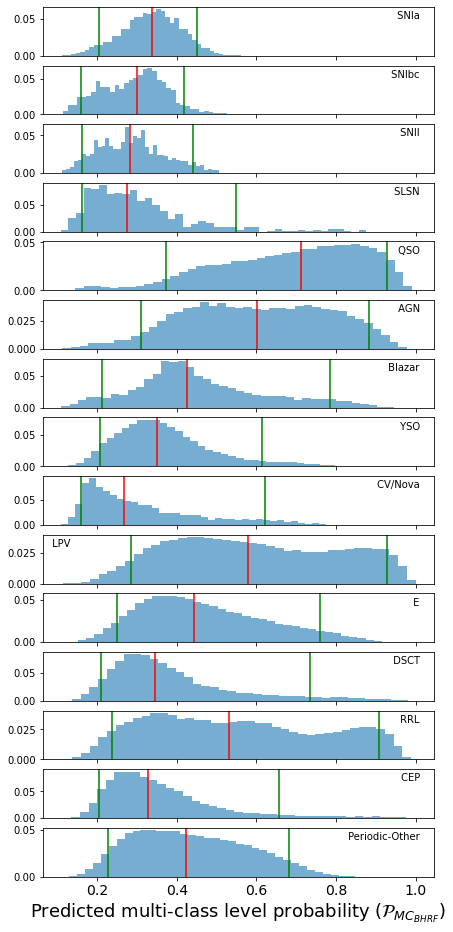

In [29]:
#plotting multi-class level probabilities

fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(7, 16), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   weights = np.ones_like(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values)/float(len(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values))
   nn,binsn,aux=ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='stepfilled', bins=40, lw=5, label=cl, alpha=0.6)
   if (cl=="LPV"): 
       ax[idx].text(0.08, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='left')
   else: 
       ax[idx].text(1.01, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='right')

plt.xticks(fontsize = 14)

ax[len(label_order)-1].set_xlabel(r'Predicted multi-class level probability ($\mathcal{P}_{MC_{BHRF}}$)',fontsize=18)
plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/prob_dist_unlabeled_set.pdf',bbox_inches='tight')

In [30]:
#for SN stats in paper
np.percentile(test_data_withclass['SLSN_prob'][test_data_withclass['predicted_class']=="SNII"].values, 50)


0.191976

[ 0.28745954  0.01148621 -0.00761852 ...  0.07376862  0.05683932
  0.24931978]


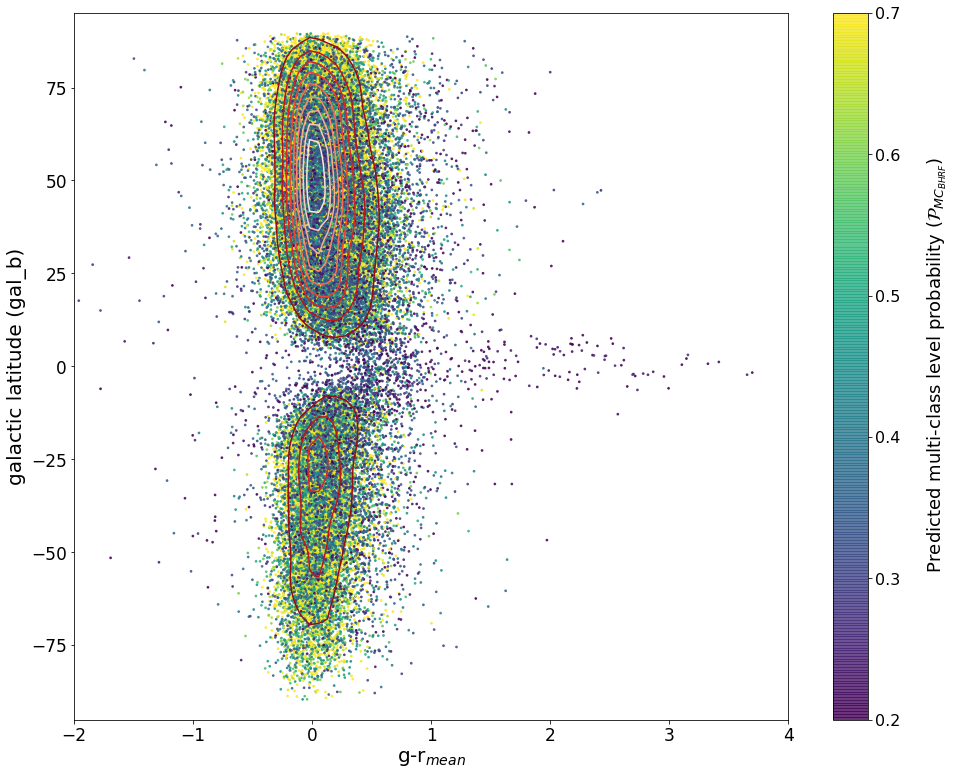

In [31]:
import matplotlib.cm as cm
import seaborn as sns

feature_x = 'g-r_mean'
feature_y = 'gal_b'
labels_list = ['QSO','AGN','Blazar','SLSN','SNII','SNIa','SNIbc']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
color_list = []

for idx, cl in enumerate(labels_list):
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 3,label=cl)
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   color_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
    
gal_b_array = np.array(gal_b_list)
color_array = np.array(color_list)

print(color_array)

ax = sns.kdeplot(color_array,gal_b_array, n_levels=10, cmap="Reds_r", shade=False)
    
cbar = plt.colorbar(sc)
cbar.set_label('\n Predicted multi-class level probability ($\mathcal{P}_{MC_{BHRF}}$) ', rotation=90,fontsize=18)

#plt.legend(fontsize=15)
plt.xlabel(r'g-r$_{mean}$',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=16)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/color_gal_b_selection_extragalactic.png',bbox_inches='tight',dpi=200)

[ 90.84914758  94.20044171 129.64863024 ... 147.90290087 128.77840965
 104.20778198]


/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


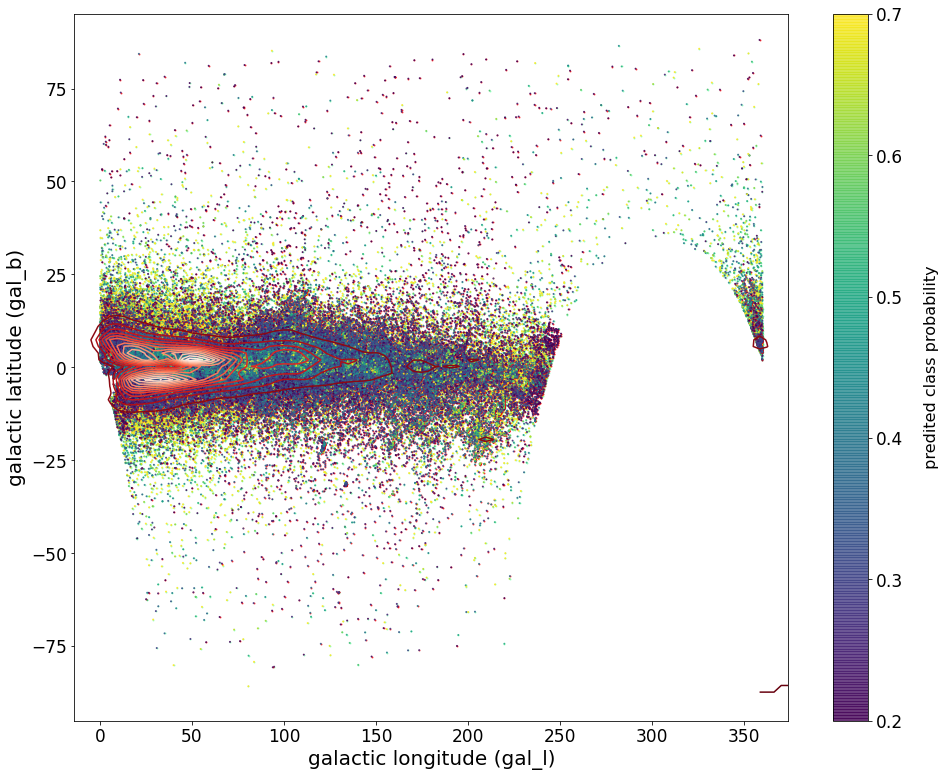

In [32]:
import matplotlib.cm as cm

feature_x = 'gal_l'
feature_y = 'gal_b'
labels_list = ['Ceph','LPV','YSO']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
#ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
gal_l_list = []


for idx, cl in enumerate(labels_list):
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.65, s = 1,label=cl)
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 1,label=cl)
   ax.tick_params(labelsize=12)  
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   gal_l_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
   

gal_b_array = np.array(gal_b_list)
gal_l_array = np.array(gal_l_list)

print(gal_l_array)

ax = sns.kdeplot(gal_l_array,gal_b_array, n_levels=15, cmap="Reds_r", shade=False, linewidth = 0.05)


cbar = plt.colorbar(sc)
cbar.set_label('\n predited class probability ', rotation=90,fontsize=16)

#plt.legend(fontsize=15)
plt.xlabel(r'galactic longitude (gal_l)',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=17)
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/gal_l_gal_b_selection_galactic.png',bbox_inches='tight',dpi=200)

[177.64783496 181.92578411 198.1811498  ... 121.96778866 237.72013552
 129.68462631]


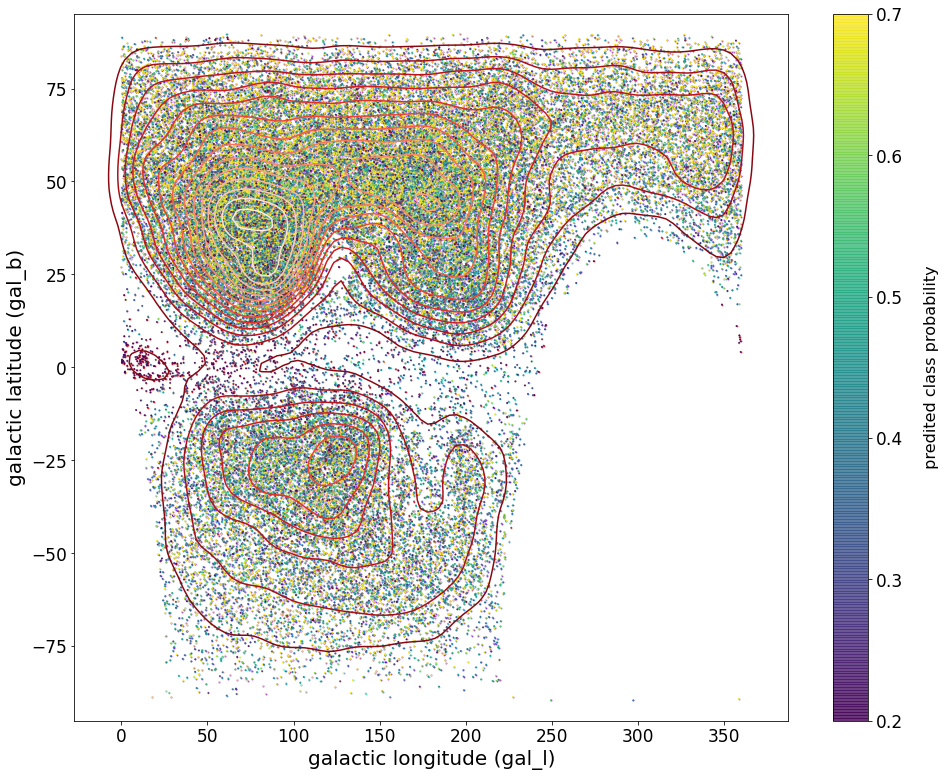

In [33]:
import matplotlib.cm as cm

feature_x = 'gal_l'
feature_y = 'gal_b'
labels_list = ['QSO','AGN','Blazar','SLSN','SNII','SNIa','SNIbc']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
#ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
gal_l_list = []


for idx, cl in enumerate(labels_list):
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.65, s = 1,label=cl)
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 1,label=cl)
   ax.tick_params(labelsize=12)  
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   gal_l_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
   

gal_b_array = np.array(gal_b_list)
gal_l_array = np.array(gal_l_list)

print(gal_l_array)

ax = sns.kdeplot(gal_l_array,gal_b_array, n_levels=15, cmap="Reds_r", shade=False, linewidth = 0.05)


cbar = plt.colorbar(sc)
cbar.set_label('\n predited class probability ', rotation=90,fontsize=16)

#plt.legend(fontsize=15)
plt.xlabel(r'galactic longitude (gal_l)',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=17)
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/gal_l_gal_b_selection_extragalactic.png',bbox_inches='tight',dpi=200)

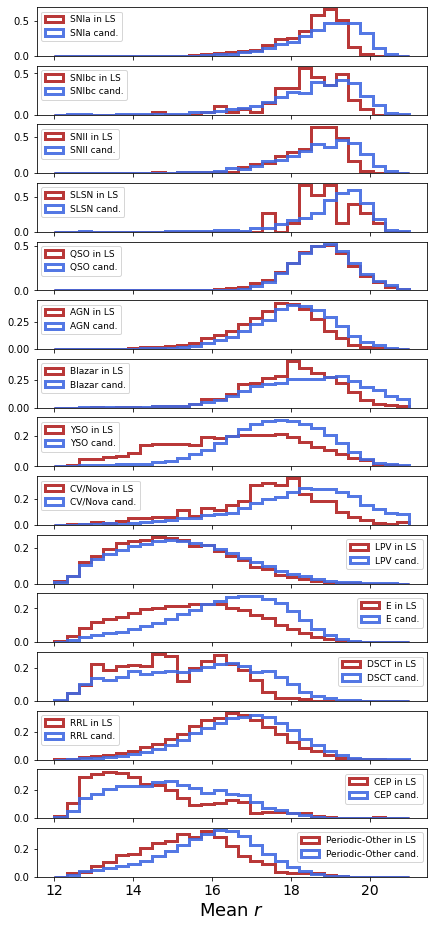

In [34]:
#magnitude distributions for labeled set and predictions in the unlabeled set
feature = 'Mean_2'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order),ncols=1, figsize=(7,16), sharex=True)


bins_hist = np.linspace(12,21,30)

for idx, cl in enumerate(label_order):
   
   if idx<=14:
       ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, cumulative=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label=cl+' in LS', alpha=0.9)
       ax[idx].hist(test_data_withclass[feature][test_data_withclass['predicted_class']==cl].values, cumulative=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label=cl+' cand.', alpha=0.9)
       
       if ((cl=="Periodic-Other") | (cl=="E") | (cl=="DSCT") | (cl=="CEP") | (cl=="LPV") ): ax[idx].legend(loc='upper right',fontsize=9)
        
       else: ax[idx].legend(loc='upper left',fontsize=9)
   
   else:
        break


ax[len(label_order)-1].set_xlabel(r'Mean $r$',fontsize=18)
plt.xticks(fontsize = 14)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/Rband_magnitude_dist.pdf',bbox_inches='tight')

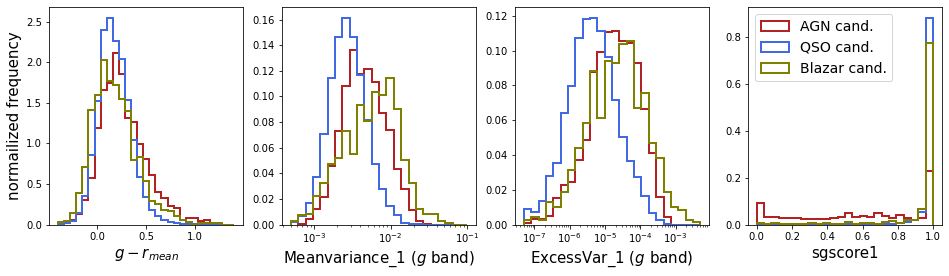

In [35]:
# for AGN analysis
df_for_figures = labels.join(test_data_withclass,how='left')


fig, ax = plt.subplots(nrows=1, ncols= 4, figsize = (16,4)) 


test_data_withclass


feature='g-r_mean_corr'
bins_hist = np.linspace(-0.4,1.4,30)#np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
ax[0].hist(df_for_figures[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values, cumulative=False, stacked=False, density=True, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
ax[0].hist(df_for_figures[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values, cumulative=False, stacked=False, density=True, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)
ax[0].hist(df_for_figures[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values, cumulative=False, stacked=False, density=True, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar cand.', alpha=1.0)
#ax[0].legend(loc='upper right',fontsize=17)
ax[0].set_xlabel(r'$g-r_{mean}$',fontsize=15)
ax[0].set_ylabel(r'normailized frequency',fontsize=15)

feature='Meanvariance_1'
bins_hist = np.logspace(np.log10(5e-4),np.log10(0.1),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values))
ax[1].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values))
ax[1].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values))
ax[1].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar cand.', alpha=1.0)
#ax[1].legend(loc='upper right',fontsize=17)
ax[1].set_xlabel(r'Meanvariance_1 ($g$ band)',fontsize=15)
#ax[1].set_ylabel(r'normailized frequency',fontsize=15)
ax[1].set_xscale('log')

feature='ExcessVar_1'
bins_hist = np.logspace(np.log10(5e-8),np.log10(0.005),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values))
ax[2].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values))
ax[2].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values))
ax[2].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar cand.', alpha=1.0)
#ax[2].legend(loc='upper left',fontsize=17)
ax[2].set_xlabel(r'ExcessVar_1 ($g$ band)',fontsize=15)
#ax[2].set_ylabel(r'normailized frequency',fontsize=15)
ax[2].set_xscale('log')


feature='sgscore1'
bins_hist = np.linspace(0,1,25,endpoint=True)#np.logspace(np.log10(2e-4),np.log10(1500),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values))
ax[3].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values))
ax[3].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values))
ax[3].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar cand.', alpha=1.0)
ax[3].legend(loc='upper left',fontsize=14)
ax[3].set_xlabel(r'sgscore1',fontsize=15)
#ax[3].set_ylabel(r'normailized frequency',fontsize=15)



plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/QSO_as_QSO_or_AGN.pdf',bbox_inches='tight')




In [52]:
np.percentile(test_data_withclass['SNII_prob'][test_data_withclass['predicted_class']=="SNII"].values, 50)



0.28302799999999995

             classALeRCE          ra        dec period     source  \
oid                                                                 
ZTF18aamqrac         AGN  176.270875  19.606328    NaN  MILLIQUAS   
ZTF18acekfly         AGN    6.079550  -1.638224    NaN  MILLIQUAS   
ZTF18aboilah         AGN  193.782373  78.620905    NaN  MILLIQUAS   
ZTF18actfpys         AGN  109.187870   0.463816    NaN  MILLIQUAS   
ZTF18acbwgej         AGN  170.996475  41.598085    NaN  MILLIQUAS   
...                  ...         ...        ...    ...        ...   
ZTF18aacekvo         QSO  132.432095  45.006733    NaN  MILLIQUAS   
ZTF19aalubxm         QSO  251.631962  21.206020    NaN  MILLIQUAS   
ZTF18abzweqf         AGN  340.306434  -1.352466    NaN  MILLIQUAS   
ZTF18accnhuo         AGN  149.327986  28.527689    NaN     Oh2015   
ZTF19abdyxsl         QSO    6.221603   6.946754    NaN  MILLIQUAS   

                              id_source          class_source  \
oid                                  

Text(0.5, 0, 'sgscore1')

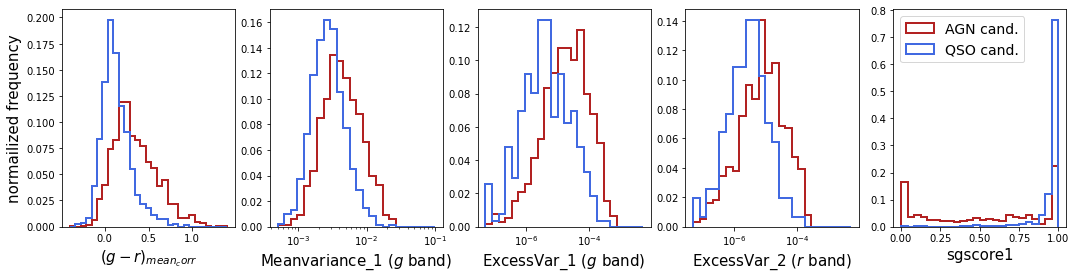

In [37]:
class_qso = '../ZTF_classifications/QSO_AGN_classifications_SIMBAD_as_seyfert_QSO_comparison.csv'

df_for_figures = pd.read_csv(class_qso,index_col='oid')

print(df_for_figures)

fig, ax = plt.subplots(nrows=1, ncols= 5, figsize = (18,4)) 


feature='g-r_mean_corr'
bins_hist = np.linspace(-0.4,1.4,30)#np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='AGN')].values)/float(len(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='AGN')].values))
ax[0].hist(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='AGN')].values,  weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='QSO')].values)/float(len(df_for_figures_aux[feature][ (df_for_figures_aux['predicted_class']=='QSO')].values))
ax[0].hist(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='QSO')].values,  weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)
#ax[0].hist(df_for_figures[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values, cumulative=False, stacked=False, density=True, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar cand.', alpha=1.0)
#ax[0].legend(loc='upper right',fontsize=17)
ax[0].set_xlabel(r'$(g-r)_{mean_corr}$',fontsize=15)
ax[0].set_ylabel(r'normailized frequency',fontsize=15)

feature='Meanvariance_1'
bins_hist = np.logspace(np.log10(5e-4),np.log10(0.1),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='AGN')].values)/float(len(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='AGN')].values))
ax[1].hist(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='AGN')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='QSO')].values)/float(len(df_for_figures_aux[feature][ (df_for_figures_aux['predicted_class']=='QSO')].values))
ax[1].hist(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='QSO')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)
#weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values))
#ax[1].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar cand.', alpha=1.0)
#ax[1].legend(loc='upper right',fontsize=17)
ax[1].set_xlabel(r'Meanvariance_1 ($g$ band)',fontsize=15)
#ax[1].set_ylabel(r'normailized frequency',fontsize=15)
ax[1].set_xscale('log')

feature='ExcessVar_1'
bins_hist = np.logspace(np.log10(5e-8),np.log10(0.005),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='AGN')].values)/float(len(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='AGN')].values))
ax[2].hist(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='AGN')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='QSO')].values)/float(len(df_for_figures_aux[feature][ (df_for_figures_aux['predicted_class']=='QSO')].values))
ax[2].hist(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='QSO')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)
#weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values))
#ax[2].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar cand.', alpha=1.0)
#ax[2].legend(loc='upper right',fontsize=17)
ax[2].set_xlabel(r'ExcessVar_1 ($g$ band)',fontsize=15)
#ax[2].set_ylabel(r'normailized frequency',fontsize=15)
ax[2].set_xscale('log')

feature='ExcessVar_2'
bins_hist = np.logspace(np.log10(5e-8),np.log10(0.005),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][ (df_for_figures_aux['predicted_class']=='AGN')].values)/float(len(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='AGN')].values))
ax[3].hist(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='AGN')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][ (df_for_figures_aux['predicted_class']=='QSO')].values)/float(len(df_for_figures_aux[feature][ (df_for_figures_aux['predicted_class']=='QSO')].values))
ax[3].hist(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='QSO')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)
#weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values))
#ax[3].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar cand.', alpha=1.0)
#ax[3].legend(loc='upper left',fontsize=17)
ax[3].set_xlabel(r'ExcessVar_2 ($r$ band)',fontsize=15)
#ax[3].set_ylabel(r'normailized frequency',fontsize=15)
ax[3].set_xscale('log')


feature='sgscore1'
bins_hist = np.linspace(0,1,25,endpoint=True)#np.logspace(np.log10(2e-4),np.log10(1500),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='AGN')].values)/float(len(df_for_figures_aux[feature][ (df_for_figures_aux['predicted_class']=='AGN')].values))
ax[4].hist(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='AGN')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='QSO')].values)/float(len(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='QSO')].values))
ax[4].hist(df_for_figures_aux[feature][(df_for_figures_aux['predicted_class']=='QSO')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)
#weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values))
#ax[4].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar cand.', alpha=1.0)
ax[4].legend(loc='upper left',fontsize=14)
ax[4].set_xlabel(r'sgscore1',fontsize=15)
#ax[4].set_ylabel(r'normailized frequency',fontsize=15)



#plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/QSO_as_QSO_or_AGN.pdf',bbox_inches='tight')



[-0.4        -0.33793103 -0.27586207 -0.2137931  -0.15172414 -0.08965517
 -0.02758621  0.03448276  0.09655172  0.15862069  0.22068966  0.28275862
  0.34482759  0.40689655  0.46896552  0.53103448  0.59310345  0.65517241
  0.71724138  0.77931034  0.84137931  0.90344828  0.96551724  1.02758621
  1.08965517  1.15172414  1.2137931   1.27586207  1.33793103  1.4       ]
[0.0005     0.00062351 0.00077754 0.00096961 0.00120914 0.00150783
 0.0018803  0.00234479 0.00292402 0.00364633 0.00454708 0.00567034
 0.00707107 0.00881782 0.01099607 0.01371241 0.01709976 0.02132388
 0.02659148 0.03316032 0.04135186 0.05156693 0.06430541 0.08019065
 0.1       ]
[0.0005     0.00062351 0.00077754 0.00096961 0.00120914 0.00150783
 0.0018803  0.00234479 0.00292402 0.00364633 0.00454708 0.00567034
 0.00707107 0.00881782 0.01099607 0.01371241 0.01709976 0.02132388
 0.02659148 0.03316032 0.04135186 0.05156693 0.06430541 0.08019065
 0.1       ]


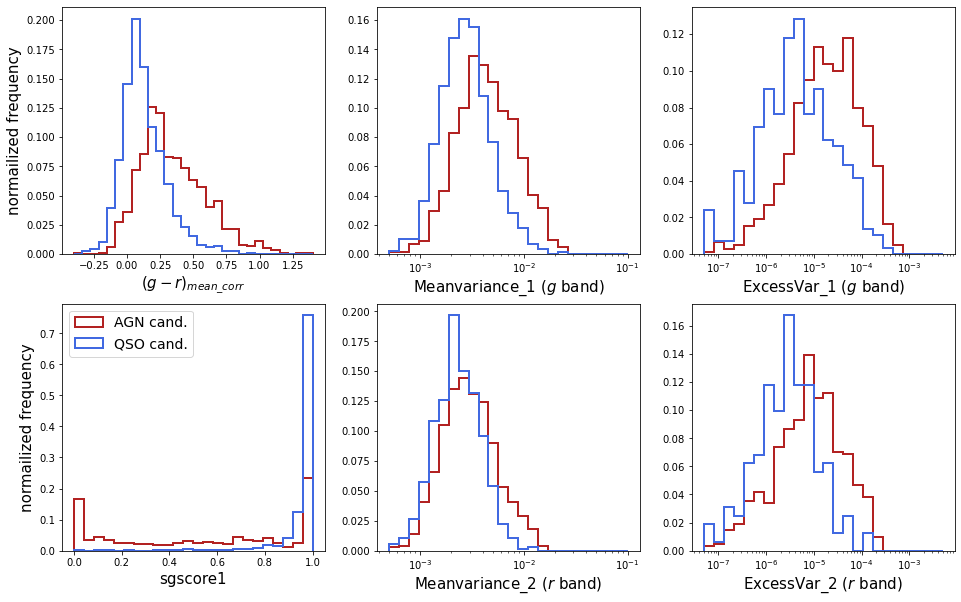

In [48]:
class_qso = '../ZTF_classifications/QSO_AGN_classifications_SIMBAD_as_seyfert_QSO_comparison.csv'

df_for_figures = pd.read_csv(class_qso,index_col='oid')

#print(df_for_figures)


fig, ax = plt.subplots(nrows=2, ncols= 3, figsize = (16,10)) 


feature='g-r_mean_corr'
bins_hist = np.linspace(-0.4,1.4,30)#np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values))
ax[0,0].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values,  weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values))
ax[0,0].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values,  weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)

ax[0,0].set_xlabel(r'$(g-r)_{mean\_corr}$',fontsize=15)
ax[0,0].set_ylabel(r'normailized frequency',fontsize=15)

feature='Meanvariance_1'
bins_hist = np.logspace(np.log10(5e-4),np.log10(0.1),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values))
ax[0,1].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values))
ax[0,1].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)

ax[0,1].set_xlabel(r'Meanvariance_1 ($g$ band)',fontsize=15)
#ax[0,1].set_ylabel(r'normailized frequency',fontsize=15)
ax[0,1].set_xscale('log')

feature='Meanvariance_2'
bins_hist = np.logspace(np.log10(5e-4),np.log10(0.1),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values))
ax[1,1].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values))
ax[1,1].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)

ax[1,1].set_xlabel(r'Meanvariance_2 ($r$ band)',fontsize=15)
#ax[1,1].set_ylabel(r'normailized frequency',fontsize=15)
ax[1,1].set_xscale('log')

feature='ExcessVar_1'
bins_hist = np.logspace(np.log10(5e-8),np.log10(0.005),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values))
ax[0,2].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values))
ax[0,2].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)

ax[0,2].set_xlabel(r'ExcessVar_1 ($g$ band)',fontsize=15)
#ax[0,2].set_ylabel(r'normailized frequency',fontsize=15)
ax[0,2].set_xscale('log')

feature='ExcessVar_2'
bins_hist = np.logspace(np.log10(5e-8),np.log10(0.005),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values))
ax[1,2].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values))
ax[1,2].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)

ax[1,2].set_xlabel(r'ExcessVar_2 ($r$ band)',fontsize=15)
#ax[1,2].set_ylabel(r'normailized frequency',fontsize=15)
ax[1,2].set_xscale('log')


feature='sgscore1'
bins_hist = np.linspace(0,1,25,endpoint=True)#np.logspace(np.log10(2e-4),np.log10(1500),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values))
ax[1,0].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values))
ax[1,0].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)

ax[1,0].legend(loc='upper left',fontsize=14)
ax[1,0].set_xlabel(r'sgscore1',fontsize=15)
ax[1,0].set_ylabel(r'normailized frequency',fontsize=15)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/QSO_as_QSO_or_AGN.pdf',bbox_inches='tight')



/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


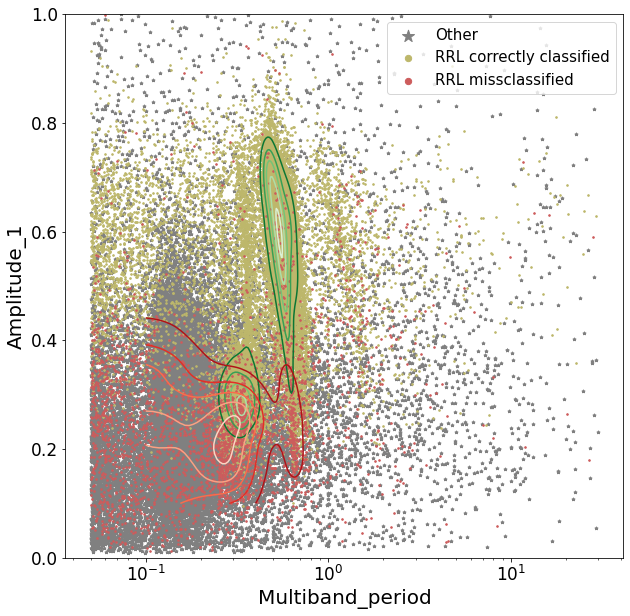

In [39]:
#magnitude distributions for labeled set and predictions in the unlabeled set
feature_x = 'Multiband_period'
feature_y = 'Amplitude_1'
logscale = False
df_train_plot = df_train.join(test_data_withclass[['predicted_class']],how='left')
df_train_plot = df_train_plot.loc[df_train_plot[feature_y]>0] 
df_train_plot = df_train_plot.loc[(df_train_plot[feature_x]>0.01) & (df_train_plot[feature_x]<30)] 

#print(df_train_plot)

fig, ax = plt.subplots(figsize=(10, 10))

plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="E"].values,df_train_plot[feature_y][df_train_plot['class_original']=="E"].values,c='grey',s=10,marker='*',label="Other")#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="DSCT"].values,df_train_plot[feature_y][df_train_plot['class_original']=="DSCT"].values,c='grey',s=10,marker='*')#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="CEP"].values,df_train_plot[feature_y][df_train_plot['class_original']=="CEP"].values,c='grey',s=10,marker='*')#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']=="RRL")].values,df_train_plot[feature_y][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']=="RRL")].values,c='darkkhaki',s=10,marker='.',label="RRL correctly classified")#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']!="RRL")].values,df_train_plot[feature_y][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']!="RRL")].values,c='indianred',s=10,marker='.',label="RRL missclassified")#,alpha=0.3)



#ax = sns.kdeplot(df_train_plot[feature_x][df_train_plot['class_original']=="E"].values,df_train_plot[feature_y][df_train_plot['class_original']=="E"].values, n_levels=5, cmap="Greens_r", shade=False)
#ax = sns.kdeplot(df_train_plot[feature_x][df_train_plot['class_original']=="DSCT"].values,df_train_plot[feature_y][df_train_plot['class_original']=="DSCT"].values, n_levels=5, cmap="Blues_r", shade=False)
ax = sns.kdeplot(df_train_plot[feature_x][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']=="RRL")].values,df_train_plot[feature_y][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']=="RRL")].values, n_levels=5,clip=(0.1,1), linewidth=6,cmap="Greens_r", shade=False)
ax = sns.kdeplot(df_train_plot[feature_x][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']!="RRL")].values,df_train_plot[feature_y][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']!="RRL")].values, n_levels=5,clip=(0.1,1), linewidth=6,cmap="Reds_r", shade=False)


#plt.text(1.,-0.53,'E',color='olive', fontsize=18)
#plt.text(1.,-0.53,'DSCT',color='lightsteelblue', fontsize=18)
#plt.text(1.,-0.53,'CEP',color='silver', fontsize=18)
#plt.text(1.,-0.4,'RRL ',color='lightcoral', fontsize=18)



plt.xlabel(r'Multiband_period',fontsize=20)
plt.ylabel(r'Amplitude_1',fontsize=20)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.xscale('log')
#plt.locator_params(axis='y', nbins=6)
#plt.locator_params(axis='x', nbins=6)
#plt.xlim(0.01,20)
plt.ylim(0,1)

plt.legend(fontsize=15,markerscale=4.)



plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/Multiband_period_vs_amplitude_g.pdf',bbox_inches='tight')

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


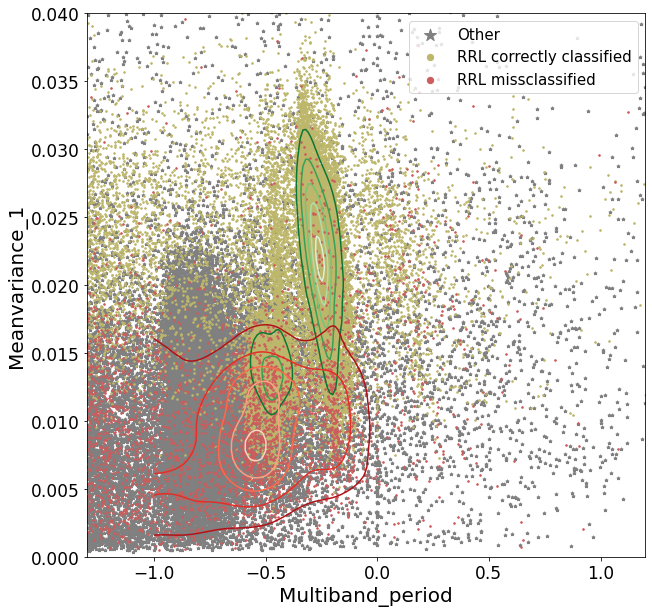

In [40]:
#magnitude distributions for labeled set and predictions in the unlabeled set
feature_x = 'log(Multiband_period)'
feature_y = 'Meanvariance_1'
logscale = False

df_train_plot = df_train.join(test_data_withclass[['predicted_class']],how='left')
df_train_plot = df_train_plot.join(df_labels[['class_source']],how='left')
df_train_plot['log(Multiband_period)']=np.log10(df_train_plot['Multiband_period'])

df_train_plot = df_train_plot.loc[df_train_plot[feature_y]>0] 
#df_train_plot = df_train_plot.loc[(df_train_plot[feature_x]>0.01) & (df_train_plot[feature_x]<30)] 



#print(df_train_plot)

fig, ax = plt.subplots(figsize=(10, 10))

plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="E"].values,df_train_plot[feature_y][df_train_plot['class_original']=="E"].values,c='grey',s=10,marker='*',label="Other")#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="DSCT"].values,df_train_plot[feature_y][df_train_plot['class_original']=="DSCT"].values,c='grey',s=10,marker='*')#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="CEP"].values,df_train_plot[feature_y][df_train_plot['class_original']=="CEP"].values,c='grey',s=10,marker='*')#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']=="RRL")].values,df_train_plot[feature_y][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']=="RRL")].values,c='darkkhaki',s=10,marker='.',label="RRL correctly classified")#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']!="RRL")].values,df_train_plot[feature_y][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']!="RRL")].values,c='indianred',s=10,marker='.',label="RRL missclassified")#,alpha=0.3)



#ax = sns.kdeplot(df_train_plot[feature_x][df_train_plot['class_original']=="E"].values,df_train_plot[feature_y][df_train_plot['class_original']=="E"].values, n_levels=5, cmap="Greens_r", shade=False)
#ax = sns.kdeplot(df_train_plot[feature_x][df_train_plot['class_original']=="DSCT"].values,df_train_plot[feature_y][df_train_plot['class_original']=="DSCT"].values, n_levels=5, cmap="Blues_r", shade=False)
ax = sns.kdeplot(df_train_plot[feature_x][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']=="RRL")].values,df_train_plot[feature_y][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']=="RRL")].values, n_levels=5,clip=(-1,0.2), linewidth=6,cmap="Greens_r", shade=False)
ax = sns.kdeplot(df_train_plot[feature_x][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']!="RRL")].values,df_train_plot[feature_y][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']!="RRL")].values, n_levels=5,clip=(-1,0.2), linewidth=6,cmap="Reds_r", shade=False)


#plt.text(1.,-0.53,'E',color='olive', fontsize=18)
#plt.text(1.,-0.53,'DSCT',color='lightsteelblue', fontsize=18)
#plt.text(1.,-0.53,'CEP',color='silver', fontsize=18)
#plt.text(1.,-0.4,'RRL ',color='lightcoral', fontsize=18)



plt.xlabel(r'Multiband_period',fontsize=20)
plt.ylabel(r'Meanvariance_1',fontsize=20)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
#plt.xscale('log')
##plt.locator_params(axis='y', nbins=6)
#plt.locator_params(axis='x', nbins=6)
#plt.xlim(0.01,20)
plt.xlim(-1.3,1.2)
plt.ylim(0,0.04)

plt.legend(fontsize=15,markerscale=4.)



plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/Multiband_period_vs_meanvariance_classifiedRRL_g.png',bbox_inches='tight')

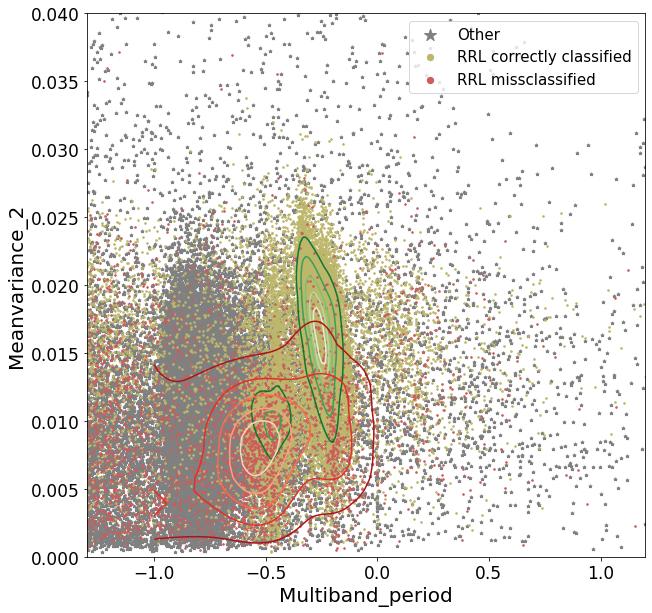

In [41]:
#magnitude distributions for labeled set and predictions in the unlabeled set
feature_x = 'log(Multiband_period)'
feature_y = 'Meanvariance_2'
logscale = False

df_train_plot = df_train.join(test_data_withclass[['predicted_class']],how='left')
df_train_plot = df_train_plot.join(df_labels[['class_source']],how='left')
df_train_plot['log(Multiband_period)']=np.log10(df_train_plot['Multiband_period'])

df_train_plot = df_train_plot.loc[df_train_plot[feature_y]>0] 
#df_train_plot = df_train_plot.loc[(df_train_plot[feature_x]>0.01) & (df_train_plot[feature_x]<30)] 



#print(df_train_plot)

fig, ax = plt.subplots(figsize=(10, 10))

plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="E"].values,df_train_plot[feature_y][df_train_plot['class_original']=="E"].values,c='grey',s=10,marker='*',label="Other")#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="DSCT"].values,df_train_plot[feature_y][df_train_plot['class_original']=="DSCT"].values,c='grey',s=10,marker='*')#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="CEP"].values,df_train_plot[feature_y][df_train_plot['class_original']=="CEP"].values,c='grey',s=10,marker='*')#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']=="RRL")].values,df_train_plot[feature_y][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']=="RRL")].values,c='darkkhaki',s=10,marker='.',label="RRL correctly classified")#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']!="RRL")].values,df_train_plot[feature_y][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']!="RRL")].values,c='indianred',s=10,marker='.',label="RRL missclassified")#,alpha=0.3)



#ax = sns.kdeplot(df_train_plot[feature_x][df_train_plot['class_original']=="E"].values,df_train_plot[feature_y][df_train_plot['class_original']=="E"].values, n_levels=5, cmap="Greens_r", shade=False)
#ax = sns.kdeplot(df_train_plot[feature_x][df_train_plot['class_original']=="DSCT"].values,df_train_plot[feature_y][df_train_plot['class_original']=="DSCT"].values, n_levels=5, cmap="Blues_r", shade=False)
ax = sns.kdeplot(df_train_plot[feature_x][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']=="RRL")].values,df_train_plot[feature_y][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']=="RRL")].values, n_levels=5,clip=(-1,0.2), linewidth=6,cmap="Greens_r", shade=False)
ax = sns.kdeplot(df_train_plot[feature_x][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']!="RRL")].values,df_train_plot[feature_y][(df_train_plot['class_original']=="RRL") & (df_train_plot['predicted_class']!="RRL")].values, n_levels=5,clip=(-1,0.2), linewidth=6,cmap="Reds_r", shade=False)


#plt.text(1.,-0.53,'E',color='olive', fontsize=18)
#plt.text(1.,-0.53,'DSCT',color='lightsteelblue', fontsize=18)
#plt.text(1.,-0.53,'CEP',color='silver', fontsize=18)
#plt.text(1.,-0.4,'RRL ',color='lightcoral', fontsize=18)



plt.xlabel(r'Multiband_period',fontsize=20)
plt.ylabel(r'Meanvariance_2',fontsize=20)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
#plt.xscale('log')
##plt.locator_params(axis='y', nbins=6)
#plt.locator_params(axis='x', nbins=6)
#plt.xlim(0.01,20)
plt.xlim(-1.3,1.2)
plt.ylim(0,0.04)

plt.legend(fontsize=15,markerscale=4.)



plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/Multiband_period_vs_meanvariance_classifiedRRL_r.png',bbox_inches='tight')

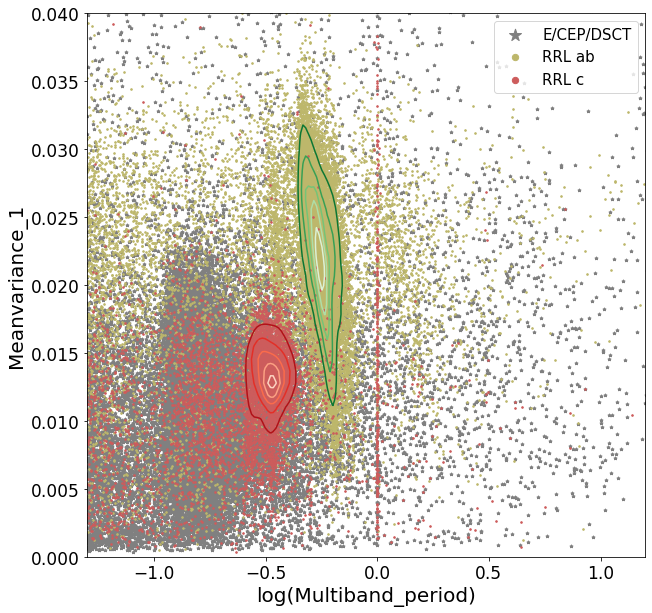

In [42]:
#magnitude distributions for labeled set and predictions in the unlabeled set
feature_x = 'log(Multiband_period)'
feature_y = 'Meanvariance_1'
logscale = False

df_train_plot = df_train.join(test_data_withclass[['predicted_class']],how='left')
df_train_plot = df_train_plot.join(df_labels[['class_source']],how='left')
df_train_plot['log(Multiband_period)']=np.log10(df_train_plot['Multiband_period'])

df_train_plot = df_train_plot.loc[df_train_plot[feature_y]>0] 
#df_train_plot = df_train_plot.loc[(df_train_plot[feature_x]>0.01) & (df_train_plot[feature_x]<30)] 

#print(df_train_plot)

fig, ax = plt.subplots(figsize=(10, 10))

plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="E"].values,df_train_plot[feature_y][df_train_plot['class_original']=="E"].values,c='grey',s=10,marker='*',label="E/CEP/DSCT")#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="DSCT"].values,df_train_plot[feature_y][df_train_plot['class_original']=="DSCT"].values,c='grey',s=10,marker='*')#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="CEP"].values,df_train_plot[feature_y][df_train_plot['class_original']=="CEP"].values,c='grey',s=10,marker='*')#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values,c='darkkhaki',s=10,marker='.',label="RRL ab")#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values,c='indianred',s=10,marker='.',label="RRL c")#,alpha=0.3)



#ax = sns.kdeplot(df_train_plot[feature_x][df_train_plot['class_original']=="E"].values,df_train_plot[feature_y][df_train_plot['class_original']=="E"].values, n_levels=5, cmap="Greens_r", shade=False)
#ax = sns.kdeplot(df_train_plot[feature_x][df_train_plot['class_original']=="DSCT"].values,df_train_plot[feature_y][df_train_plot['class_original']=="DSCT"].values, n_levels=5, cmap="Blues_r", shade=False)
ax = sns.kdeplot(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values, n_levels=5,clip=(-1,0.2), linewidth=6,cmap="Greens_r", shade=False)
ax = sns.kdeplot(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values, n_levels=5,clip=(-1,0.2), linewidth=6,cmap="Reds_r", shade=False)


#plt.text(1.,-0.53,'E',color='olive', fontsize=18)
#plt.text(1.,-0.53,'DSCT',color='lightsteelblue', fontsize=18)
#plt.text(1.,-0.53,'CEP',color='silver', fontsize=18)
#plt.text(1.,-0.4,'RRL ',color='lightcoral', fontsize=18)



plt.xlabel(r'log(Multiband_period)',fontsize=20)
plt.ylabel(r'Meanvariance_1',fontsize=20)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

#plt.locator_params(axis='y', nbins=6)
#plt.locator_params(axis='x', nbins=6)
plt.xlim(-1.3,1.2)
plt.ylim(0,0.04)
#plt.xscale('log')

plt.legend(fontsize=15,markerscale=4.)



plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/Multiband_period_vs_meanvariance_g.png',bbox_inches='tight')

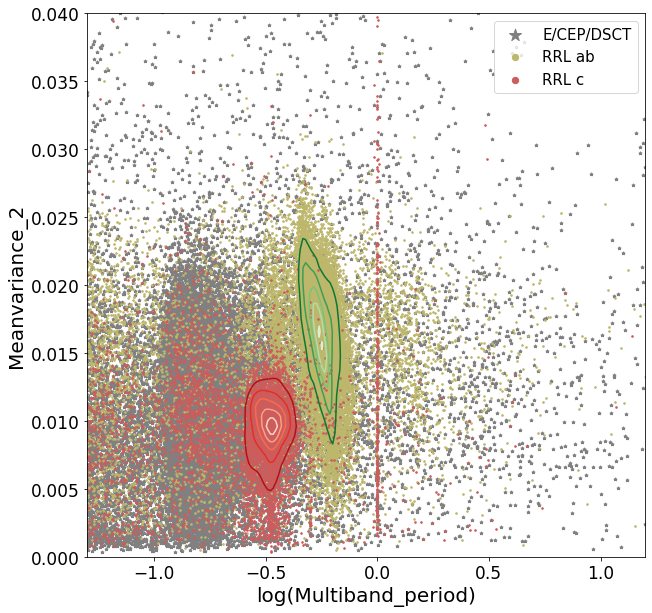

In [43]:
#magnitude distributions for labeled set and predictions in the unlabeled set
feature_x = 'log(Multiband_period)'
feature_y = 'Meanvariance_2'
logscale = False

df_train_plot = df_train.join(test_data_withclass[['predicted_class']],how='left')
df_train_plot = df_train_plot.join(df_labels[['class_source']],how='left')
df_train_plot['log(Multiband_period)']=np.log10(df_train_plot['Multiband_period'])

df_train_plot = df_train_plot.loc[df_train_plot[feature_y]>0] 
#df_train_plot = df_train_plot.loc[(df_train_plot[feature_x]>0.01) & (df_train_plot[feature_x]<30)] 

#print(df_train_plot)

fig, ax = plt.subplots(figsize=(10, 10))

plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="E"].values,df_train_plot[feature_y][df_train_plot['class_original']=="E"].values,c='grey',s=10,marker='*',label="E/CEP/DSCT")#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="DSCT"].values,df_train_plot[feature_y][df_train_plot['class_original']=="DSCT"].values,c='grey',s=10,marker='*')#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="CEP"].values,df_train_plot[feature_y][df_train_plot['class_original']=="CEP"].values,c='grey',s=10,marker='*')#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values,c='darkkhaki',s=10,marker='.',label="RRL ab")#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values,c='indianred',s=10,marker='.',label="RRL c")#,alpha=0.3)



#ax = sns.kdeplot(df_train_plot[feature_x][df_train_plot['class_original']=="E"].values,df_train_plot[feature_y][df_train_plot['class_original']=="E"].values, n_levels=5, cmap="Greens_r", shade=False)
#ax = sns.kdeplot(df_train_plot[feature_x][df_train_plot['class_original']=="DSCT"].values,df_train_plot[feature_y][df_train_plot['class_original']=="DSCT"].values, n_levels=5, cmap="Blues_r", shade=False)
ax = sns.kdeplot(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values, n_levels=5,clip=(-1,0.2), linewidth=6,cmap="Greens_r", shade=False)
ax = sns.kdeplot(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values, n_levels=5,clip=(-1,0.2), linewidth=6,cmap="Reds_r", shade=False)


#plt.text(1.,-0.53,'E',color='olive', fontsize=18)
#plt.text(1.,-0.53,'DSCT',color='lightsteelblue', fontsize=18)
#plt.text(1.,-0.53,'CEP',color='silver', fontsize=18)
#plt.text(1.,-0.4,'RRL ',color='lightcoral', fontsize=18)



plt.xlabel(r'log(Multiband_period)',fontsize=20)
plt.ylabel(r'Meanvariance_2',fontsize=20)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

#plt.locator_params(axis='y', nbins=6)
#plt.locator_params(axis='x', nbins=6)
plt.xlim(-1.3,1.2)
plt.ylim(0,0.04)
#plt.xscale('log')

plt.legend(fontsize=15,markerscale=4.)



plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/Multiband_period_vs_meanvariance_r.png',bbox_inches='tight')

oid
ZTF19aapcxhy    False
ZTF18abtmwvo    False
ZTF18acvgdfy    False
ZTF19aapuscr    False
ZTF18aaodoxr    False
                ...  
ZTF18aaxymzx    False
ZTF18abikbvc    False
ZTF19aamtoyb    False
ZTF18abnubuy    False
ZTF18abgqxlw    False
Length: 114297, dtype: bool
oid
ZTF19aapcxhy    False
ZTF18abtmwvo    False
ZTF18acvgdfy    False
ZTF19aapuscr    False
ZTF18aaodoxr    False
                ...  
ZTF18aaxymzx    False
ZTF18abikbvc    False
ZTF19aamtoyb    False
ZTF18abnubuy    False
ZTF18abgqxlw    False
Length: 114297, dtype: bool


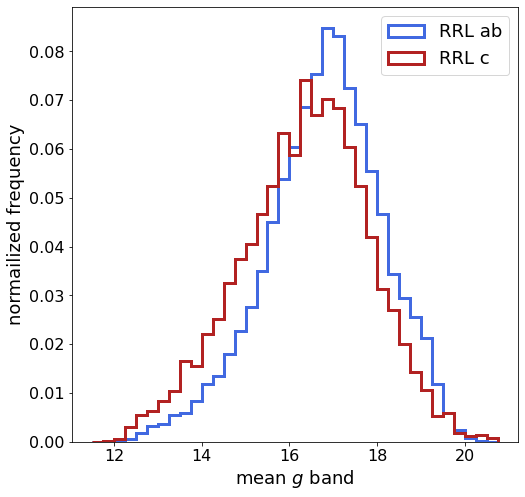

In [44]:
df_train_plot= df_train.join(test_data_withclass[['predicted_class']],how='left')

df_train_plot = df_train_plot.join(df_labels[['class_source']],how='left')

df_train_plot = df_train_plot[df_train_plot['Mean_1']>-999]

fi = plt.figure(figsize=(8,8))

bins_hist = np.arange(11.5,21,0.25)

print((df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c')))
print((df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab')))



weights = np.ones_like(df_train_plot['Mean_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))])/float(len(df_train_plot['Mean_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))]))
binss,hist,p = plt.hist(df_train_plot['Mean_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='RRL ab', alpha=1.0)


weights = np.ones_like(df_train_plot['Mean_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))])/float(len(df_train_plot['Mean_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))]))
binss,hist,p = plt.hist(df_train_plot['Mean_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='RRL c', alpha=1.0)

plt.legend(fontsize=18)

plt.xlabel(r'mean $g$ band',fontsize=18)
plt.ylabel(r'normailized frequency',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/gband_dist_RRL.pdf',bbox_inches='tight')


oid
ZTF19aapcxhy    False
ZTF18abtmwvo    False
ZTF18acvgdfy    False
ZTF19aapuscr    False
ZTF18aaodoxr    False
                ...  
ZTF18aaxymzx    False
ZTF18abikbvc    False
ZTF19aamtoyb    False
ZTF18abnubuy    False
ZTF18abgqxlw    False
Length: 114297, dtype: bool
oid
ZTF19aapcxhy    False
ZTF18abtmwvo    False
ZTF18acvgdfy    False
ZTF19aapuscr    False
ZTF18aaodoxr    False
                ...  
ZTF18aaxymzx    False
ZTF18abikbvc    False
ZTF19aamtoyb    False
ZTF18abnubuy    False
ZTF18abgqxlw    False
Length: 114297, dtype: bool


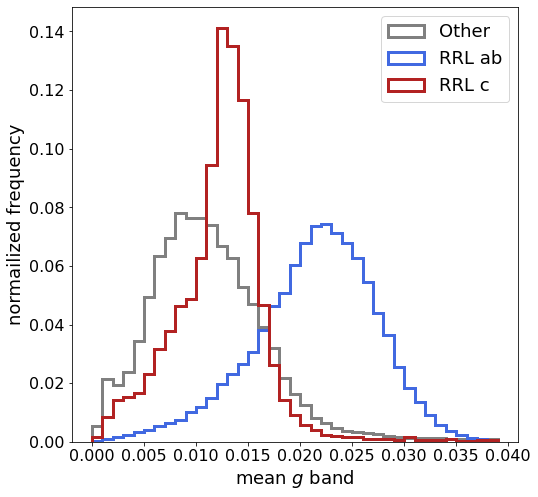

In [45]:
df_train_plot= df_train.join(test_data_withclass[['predicted_class']],how='left')

df_train_plot = df_train_plot.join(df_labels[['class_source']],how='left')

df_train_plot = df_train_plot[df_train_plot['Meanvariance_1']>-999]

fi = plt.figure(figsize=(8,8))

bins_hist = np.arange(0,0.04,0.001)

print((df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c')))
print((df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab')))


weights = np.ones_like(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='CEP') | (df_train_plot['class_original']=='E') | (df_train_plot['class_original']=='DSCT')])/float(len(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='CEP') | (df_train_plot['class_original']=='E') | (df_train_plot['class_original']=='DSCT')]))
binss,hist,p = plt.hist(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='CEP') | (df_train_plot['class_original']=='E') | (df_train_plot['class_original']=='DSCT')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "grey", ec="grey",label='Other', alpha=1.0)



weights = np.ones_like(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))])/float(len(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))]))
binss,hist,p = plt.hist(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='RRL ab', alpha=1.0)


weights = np.ones_like(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))])/float(len(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))]))
binss,hist,p = plt.hist(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='RRL c', alpha=1.0)

plt.legend(fontsize=18)

plt.xlabel(r'mean $g$ band',fontsize=18)
plt.ylabel(r'normailized frequency',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/meanvariance_gband_dist_RRL.pdf',bbox_inches='tight')

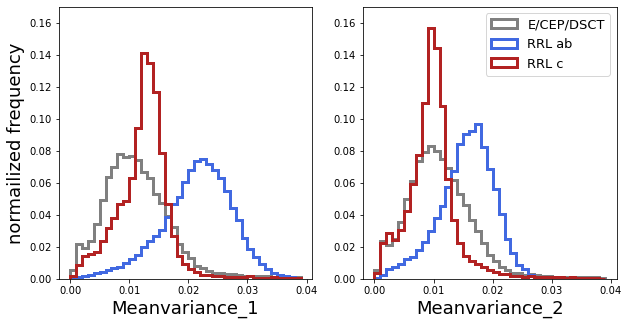

In [46]:
df_train_plot_aux= df_train.join(test_data_withclass[['predicted_class']],how='left')

df_train_plot_aux = df_train_plot_aux.join(df_labels[['class_source']],how='left')

fig, ax = plt.subplots(nrows=1, ncols= 2, figsize = (10,5)) 


df_train_plot = df_train_plot_aux[df_train_plot_aux['Meanvariance_1']>-999]

bins_hist = np.arange(0,0.04,0.001)

weights = np.ones_like(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='CEP') | (df_train_plot['class_original']=='E') | (df_train_plot['class_original']=='DSCT')])/float(len(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='CEP') | (df_train_plot['class_original']=='E') | (df_train_plot['class_original']=='DSCT')]))
ax[0].hist(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='CEP') | (df_train_plot['class_original']=='E') | (df_train_plot['class_original']=='DSCT')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "grey", ec="grey",label='E/CEP/DSCT', alpha=1.0)
weights = np.ones_like(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))])/float(len(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))]))
ax[0].hist(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='RRL ab', alpha=1.0)
weights = np.ones_like(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))])/float(len(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))]))
ax[0].hist(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='RRL c', alpha=1.0)
ax[0].set_xlabel('Meanvariance_1',fontsize=18)
ax[0].set_ylabel(r'normailized frequency',fontsize=18)
ax[0].set_ylim(0,0.17)

df_train_plot = df_train_plot_aux[df_train_plot_aux['Meanvariance_2']>-999]

bins_hist = np.arange(0,0.04,0.001)

weights = np.ones_like(df_train_plot['Meanvariance_2'][(df_train_plot['class_original']=='CEP') | (df_train_plot['class_original']=='E') | (df_train_plot['class_original']=='DSCT')])/float(len(df_train_plot['Meanvariance_2'][(df_train_plot['class_original']=='CEP') | (df_train_plot['class_original']=='E') | (df_train_plot['class_original']=='DSCT')]))
ax[1].hist(df_train_plot['Meanvariance_2'][(df_train_plot['class_original']=='CEP') | (df_train_plot['class_original']=='E') | (df_train_plot['class_original']=='DSCT')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "grey", ec="grey",label='E/CEP/DSCT', alpha=1.0)
weights = np.ones_like(df_train_plot['Meanvariance_2'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))])/float(len(df_train_plot['Meanvariance_2'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))]))
ax[1].hist(df_train_plot['Meanvariance_2'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='RRL ab', alpha=1.0)
weights = np.ones_like(df_train_plot['Meanvariance_2'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))])/float(len(df_train_plot['Meanvariance_2'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))]))
ax[1].hist(df_train_plot['Meanvariance_2'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='RRL c', alpha=1.0)
ax[1].set_xlabel('Meanvariance_2',fontsize=18)
ax[1].set_ylim(0,0.17)

plt.legend(fontsize=13,numpoints=1)


plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/meanvariance_bothbands_dist_RRL.pdf',bbox_inches='tight')